In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image,ImageChops,ImageEnhance
from tqdm import tqdm
import pandas as pd
from IPython.display import display
from scipy.stats import skew, entropy, kurtosis, randint, uniform
from skimage.feature import hog, graycomatrix, graycoprops,local_binary_pattern
from skimage import exposure
from skimage import feature
import pywt
from sklearn.decomposition import PCA
import skimage.measure
from scipy.sparse import csr_matrix, hstack, vstack
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_recall_curve,\
                                                        precision_score, recall_score, f1_score,roc_curve,auc
from sklearn.model_selection import GridSearchCV, cross_val_predict, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC  # Import SVM
from xgboost import XGBClassifier
import joblib
from catboost import CatBoostClassifier
import networkx as nx

**Images address in the local machine**

In [2]:
# Set your directories
real_image_dir = "./data/Au"  # Authentic images
fake_image_dir = "./data/Tp"  # Tampered images

**Load and labeling Images**

In [3]:
def load_images_from_folder(folder, label, target_size=(150, 150)):
    #Valid file formats
    valid_formats = {".jpg", ".png", ".bmp", ".tif", ".jpeg"}
    images = []
    labels = []
    for filename in tqdm(os.listdir(folder)):
        try:
            ext = os.path.splitext(filename)[1].lower()
            if ext not in valid_formats:
                continue # Skip the file if the format is invalid #Had to do this because of .DS_Store, hidden file.
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            if img is not None:
                img = cv2.resize(img, target_size)  # Resize to 150x150
                images.append(img)
                labels.append(label)
        except Exception as e:
            print(f"Error loading {filename}: {e}")  # Handle corrupted files
    return images, labels

# Load both real and fake images
real_images, real_labels = load_images_from_folder(real_image_dir, label=0)  # 0 for real
fake_images, fake_labels = load_images_from_folder(fake_image_dir, label=1)  # 1 for fake

# Combine the data into a single dataset
images = np.array(real_images + fake_images)
labels = np.array(real_labels + fake_labels)

print(f'Total images: {len(images)}, Real: {len(real_images)}, Fake: {len(fake_images)}')

100%|██████████████████████████████████████| 5123/5123 [00:37<00:00, 137.75it/s]


Total images: 12614, Real: 7491, Fake: 5123


**Showing some samples of authentic and fake images**

['Au_pla_20040.jpg', 'Au_nat_10105.jpg', 'Au_arc_10118.jpg', 'Au_nat_10111.jpg', 'Au_ani_00079.jpg']


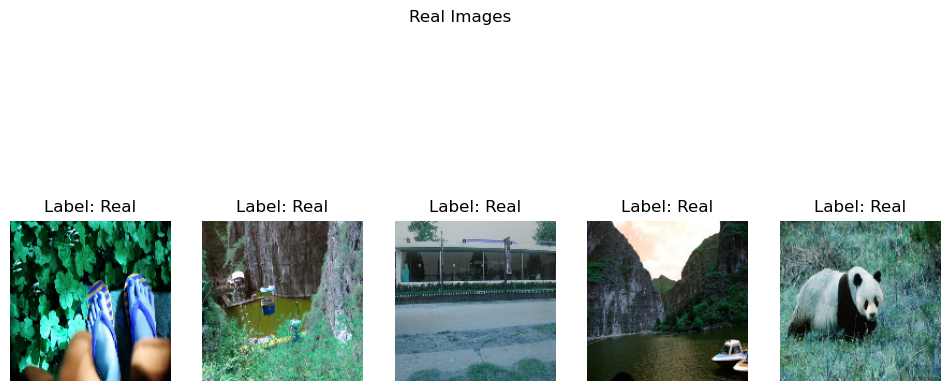

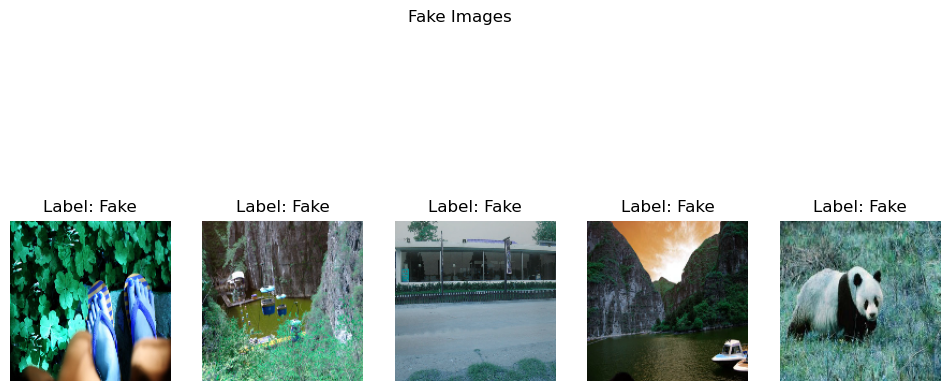

In [4]:
real_list=list(os.listdir(real_image_dir))
fake_list=list(os.listdir(fake_image_dir))
real_set=set(realname[3:12].replace("_","") for realname in real_list)
fake_set=set(filename[13:21] for filename in fake_list)
common_list=real_set.intersection(fake_set)
real_list_file=[]
real_num=[]
counter=1
for i, filename in enumerate(os.listdir(real_image_dir)):
    if filename[3:12].replace("_","") in common_list:
        real_list_file.append(filename)
        real_num.append(i)
        counter+=1
    if counter==6:
        break
print(real_list_file)
fake_num=[]
for realname in real_list_file :
    for i, filename in enumerate(os.listdir(fake_image_dir)):
        if filename[13:21]==realname[3:12].replace("_",""):
            break
    fake_num.append(i)
def display_samples(images, labels, title, n=5):
    plt.figure(figsize=(12, 6))
    if title== "Real Images":
        for j, i in enumerate(real_num):
            plt.subplot(1, n, j + 1)
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            plt.title(f"Label: {'Fake' if labels[i] == 1 else 'Real'}")
            plt.axis('off')
    else:
        for j,i in enumerate(fake_num):

            plt.subplot(1, n, j + 1)
            plt.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
            plt.title(f"Label: {'Fake' if labels[i] == 1 else 'Real'}")
            plt.axis('off')
            
    plt.suptitle(title)
    plt.show()

# Display 5 real and 5 fake images
display_samples(real_images, real_labels, "Real Images")
display_samples(fake_images, fake_labels, "Fake Images")

**Size of Images**

Unique image shapes:
(150, 150, 3)    12614
Name: count, dtype: int64


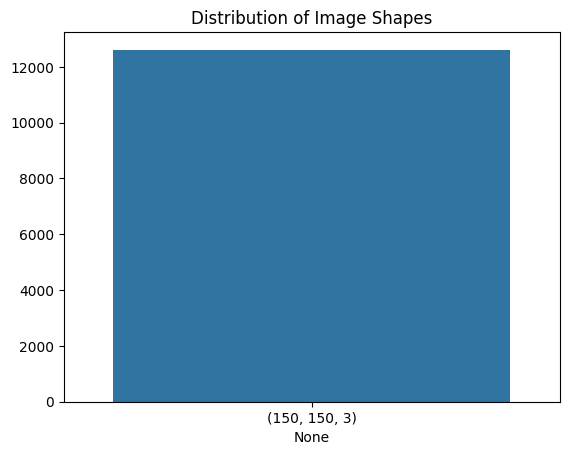

In [5]:
# Check unique image shapes
image_shapes = [img.shape for img in images]
shape_counts = pd.Series(image_shapes).value_counts()

print(f"Unique image shapes:\n{shape_counts}")

# Plot distribution of image shapes
sns.barplot(x=shape_counts.index.astype(str), y=shape_counts.values)
plt.xticks
plt.title('Distribution of Image Shapes')
plt.show()

**Comparing Green, Blue andd Red Intensity of Fake and Authentic images**

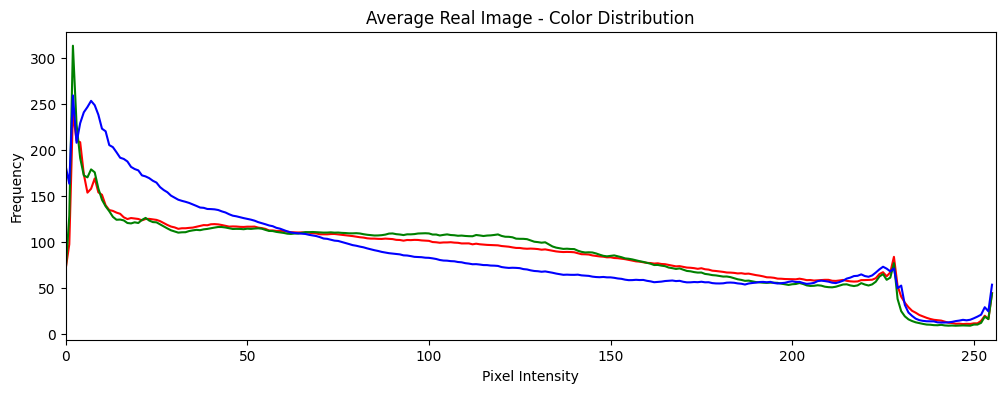

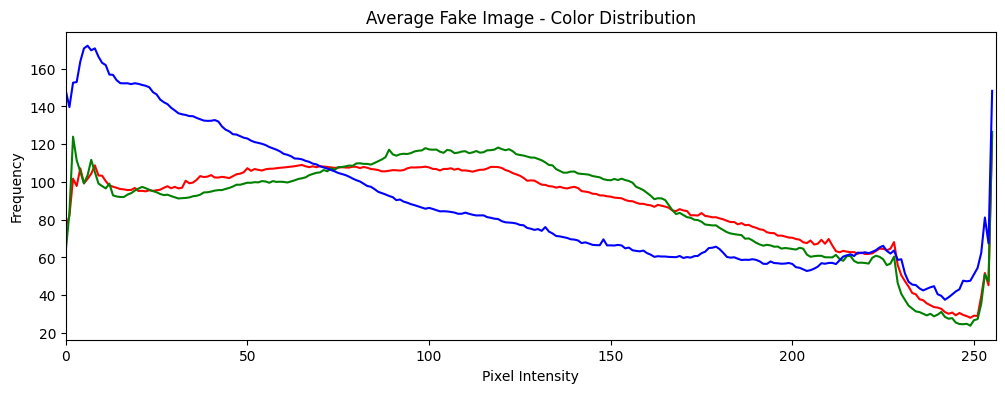

In [6]:
def compute_color_histogram(image):
    #Compute the color histogram for an image.
    histograms = []
    for i in range(3):  # For R, G, and B channels
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        histograms.append(hist.flatten())  # Flatten for easier averaging
    return np.array(histograms)  # Shape: (3, 256)

def plot_average_color_distribution(average_hist, title="Average Color Distribution"):
    #Plot the average color distribution.
    colors = ['r', 'g', 'b']
    plt.figure(figsize=(12, 4))
    for i, col in enumerate(colors):
        plt.plot(average_hist[i], color=col)
        plt.xlim([0, 256])
    plt.title(title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.show()

# Initialize accumulators for the histograms
real_hist_sum = np.zeros((3, 256))
fake_hist_sum = np.zeros((3, 256))

# Process all real images
for img in real_images:
    real_hist_sum += compute_color_histogram(img)

# Process all fake images
for img in fake_images:
    fake_hist_sum += compute_color_histogram(img)

# Compute the average histograms by dividing by the number of images
avg_real_hist = real_hist_sum / len(real_images)
avg_fake_hist = fake_hist_sum / len(fake_images)

# Plot the average color distributions
plot_average_color_distribution(avg_real_hist, "Average Real Image - Color Distribution")
plot_average_color_distribution(avg_fake_hist, "Average Fake Image - Color Distribution")


**Statistical Charectiristic of Fake and Authentic Images**

In [7]:
def extract_statistical_features(image):
    #Extract mean, standard deviation, and skewness for each color channel.
    means = np.mean(image, axis=(0, 1))
    stds = np.std(image, axis=(0, 1))
    skews = skew(image.reshape(-1, 3), axis=0)

    return {
        'mean_R': means[0], 'mean_G': means[1], 'mean_B': means[2],
        'std_R': stds[0], 'std_G': stds[1], 'std_B': stds[2],
        'skew_R': skews[0], 'skew_G': skews[1], 'skew_B': skews[2]
    }

def process_images(images):
    #Extract and average statistical features across a list of images.
    feature_list = []
    for img in images:
        feature_list.append(extract_statistical_features(img))

    # Convert list of dictionaries to a DataFrame for easy averaging
    df = pd.DataFrame(feature_list)
    avg_features = df.mean().to_dict()  # Compute average features
    return avg_features

# Process real and fake images
avg_real_features = process_images(real_images)
avg_fake_features = process_images(fake_images)

# Combine results into a single DataFrame for comparison
comparison_df = pd.DataFrame([avg_real_features, avg_fake_features], 
                             index=['Real Images', 'Fake Images'])

# Display the comparison table
print("\nAverage Statistical Features Comparison:")
print(comparison_df)

# (Optional) Display as a formatted table if running in Jupyter
try:
    
    display(comparison_df.style.set_caption("Average Statistical Features Comparison")
            .background_gradient(cmap='coolwarm', axis=1))
except ImportError:
    pass  # IPython not available; only print the DataFrame



Average Statistical Features Comparison:
                 mean_R      mean_G      mean_B      std_R      std_G  \
Real Images  100.174798   97.931520   89.552558  58.130715  56.222593   
Fake Images  112.614917  111.855565  100.780193  58.030969  56.179020   

                 std_B    skew_R    skew_G    skew_B  
Real Images  57.071042  0.367725  0.328898  0.551452  
Fake Images  60.235870  0.196780  0.176103  0.446757  


,mean_R,mean_G,mean_B,std_R,std_G,std_B,skew_R,skew_G,skew_B
Real Images,100.174798,97.931520,89.552558,58.130715,56.222593,57.071042,0.367725,0.328898,0.551452
Fake Images,112.614917,111.855565,100.780193,58.030969,56.179020,60.235870,0.196780,0.176103,0.446757


**Correlation in Fake andAuthentic Images**

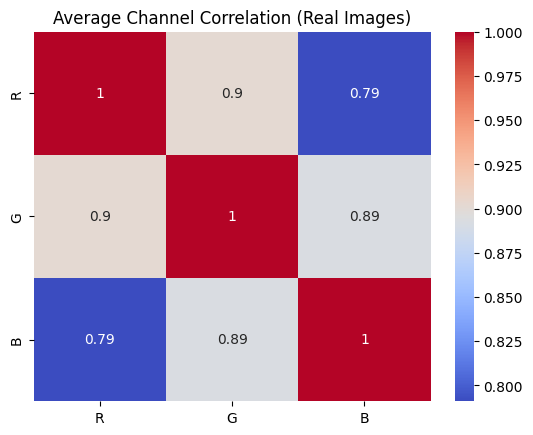

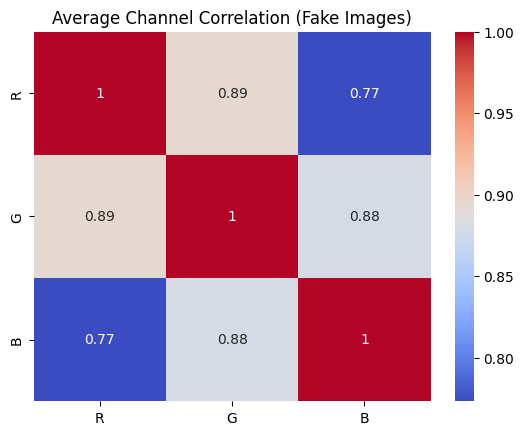

In [8]:
def channel_correlation(image):
    # Compute the correlation matrix for the RGB channels of an image.
    img_reshaped = image.reshape(-1, 3)
    corr_matrix = np.corrcoef(img_reshaped, rowvar=False)
    return corr_matrix

def average_correlation(images):
    # Compute the average correlation matrix across a list of images.
    correlation_matrices = [channel_correlation(img) for img in images]
    avg_corr_matrix = np.mean(correlation_matrices, axis=0)  # Average the matrices
    return avg_corr_matrix

def plot_correlation_matrix(corr_matrix, title):
    # Plot the correlation matrix as a heatmap.
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', 
                xticklabels=['R', 'G', 'B'], yticklabels=['R', 'G', 'B'])
    plt.title(title)
    plt.show()

# Compute average correlation matrices for real and fake images
avg_corr_real = average_correlation(real_images)
avg_corr_fake = average_correlation(fake_images)

# Plot and compare the results
plot_correlation_matrix(avg_corr_real, "Average Channel Correlation (Real Images)")
plot_correlation_matrix(avg_corr_fake, "Average Channel Correlation (Fake Images)")


**Box plot for Red, Blue and Green channels**

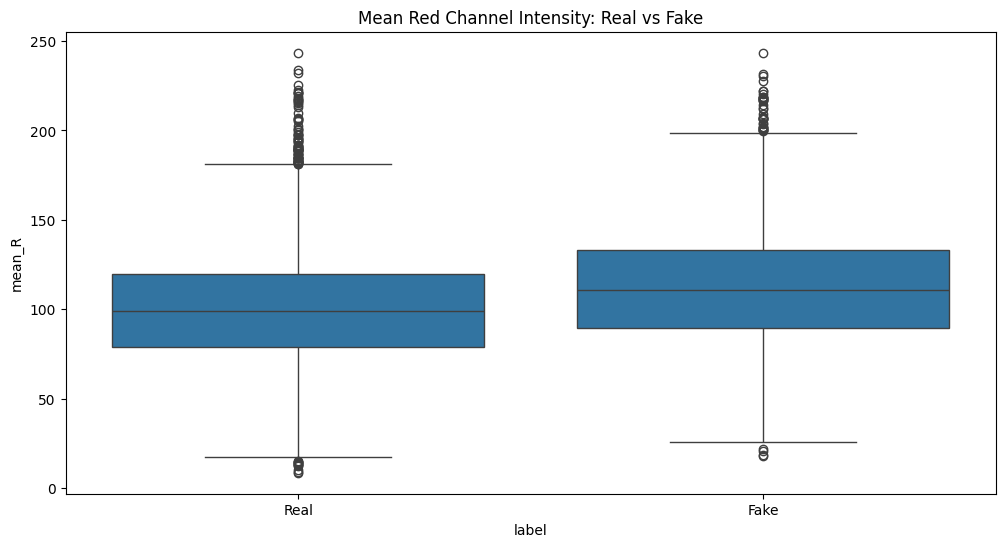

In [9]:
features = []

for img, label in zip(images, labels):
    stats = extract_statistical_features(img)
    stats['label'] = label
    features.append(stats)

df_features = pd.DataFrame(features)

# Visualize feature distributions for real vs fake
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='mean_R', data=df_features)
plt.xticks([0, 1], ['Real', 'Fake'])
plt.title('Mean Red Channel Intensity: Real vs Fake')
plt.show()

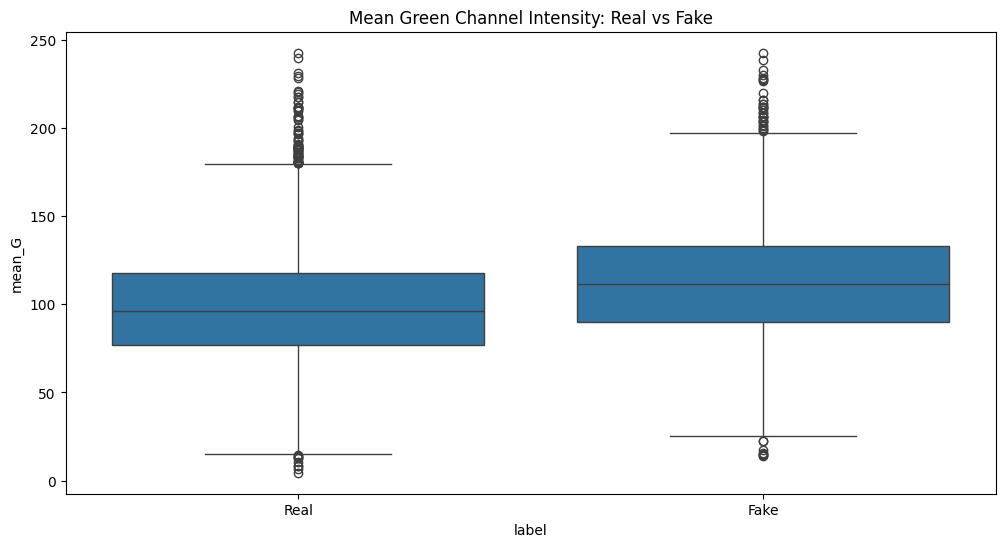

In [10]:
features = []

for img, label in zip(images, labels):
    stats = extract_statistical_features(img)
    stats['label'] = label
    features.append(stats)

df_features = pd.DataFrame(features)


# Visualize feature distributions for real vs fake
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='mean_G', data=df_features)
plt.xticks([0, 1], ['Real', 'Fake'])
plt.title('Mean Green Channel Intensity: Real vs Fake')
plt.show()

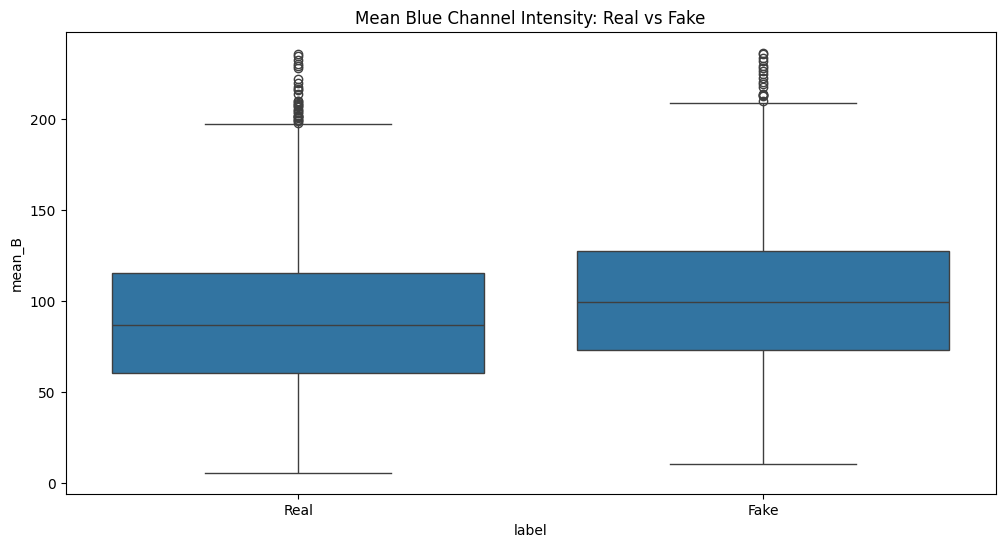

In [11]:
features = []

for img, label in zip(images, labels):
    stats = extract_statistical_features(img)
    stats['label'] = label
    features.append(stats)

df_features = pd.DataFrame(features)


# Visualize feature distributions for real vs fake
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='mean_B', data=df_features)
plt.xticks([0, 1], ['Real', 'Fake'])
plt.title('Mean Blue Channel Intensity: Real vs Fake')
plt.show()

**Histogram of Oriented Gradients (HOG)**

,Metric,Fake,Real
0,Mean HOG Value,0.136525,0.134601
1,Std HOG Value,0.095350,0.097985
2,Features Count,10404.000000,10404.000000


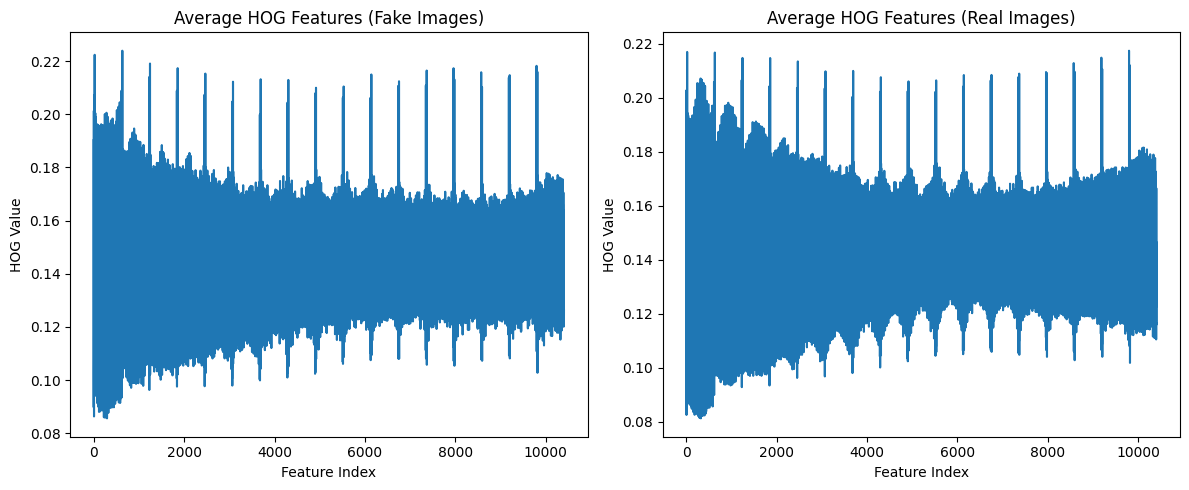

In [12]:
def compute_hog_features(images):
    #Compute HOG features for a list of images and return them as an array.
    hog_features = []
    for image in images:
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute HOG features
        features = hog(gray_image, pixels_per_cell=(8, 8), cells_per_block=(2, 2),block_norm='L2-Hys', visualize=False)
        
        hog_features.append(features)
    return np.array(hog_features)

def average_hog_features(hog_features):
    #Average HOG features across all images.
    return np.mean(hog_features, axis=0)

def compute_hog_stats(hog_features):
    # Compute statistics (mean, std) for HOG features.
    if hog_features.size == 0:
        return {'Mean HOG Value': 0, 'Std HOG Value': 0}

    mean_hog_value = np.mean(hog_features)
    std_hog_value = np.std(hog_features)

    return {
        'Mean HOG Value': mean_hog_value,
        'Std HOG Value': std_hog_value,
        'Features Count': hog_features.shape[1] if hog_features.shape[0] > 0 else 0
    }

def display_hog_stats_table(fake_features, real_features):
    # Create a comparison table for HOG statistics.
    fake_stats = compute_hog_stats(fake_features)
    real_stats = compute_hog_stats(real_features)

    # Create a DataFrame to display the statistics
    comparison_table = pd.DataFrame({
        'Metric': ['Mean HOG Value', 'Std HOG Value', 'Features Count'],
        'Fake': [fake_stats['Mean HOG Value'], fake_stats['Std HOG Value'], fake_stats['Features Count']],
        'Real': [real_stats['Mean HOG Value'], real_stats['Std HOG Value'], real_stats['Features Count']]
    })

    # Display the table
    display(comparison_table.style.set_caption("HOG Statistics Comparison").set_properties(**{'text-align': 'center'}))

def plot_hog_features(avg_hog_fake, avg_hog_real):
    #Plot average HOG features for comparison.
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(avg_hog_fake)
    ax[0].set_title('Average HOG Features (Fake Images)')
    ax[0].set_xlabel('Feature Index')
    ax[0].set_ylabel('HOG Value')
    
    ax[1].plot(avg_hog_real)
    ax[1].set_title('Average HOG Features (Real Images)')
    ax[1].set_xlabel('Feature Index')
    ax[1].set_ylabel('HOG Value')
    
    plt.tight_layout()
    plt.show()

# Compute HOG features for fake and real images
hog_features_fake = compute_hog_features(fake_images)
hog_features_real = compute_hog_features(real_images)

# Average the HOG features
avg_hog_fake = average_hog_features(hog_features_fake)
avg_hog_real = average_hog_features(hog_features_real)

# Display the HOG stats table
display_hog_stats_table(hog_features_fake, hog_features_real)

# Plot the average HOG features for comparison
plot_hog_features(avg_hog_fake, avg_hog_real)


**Scale-Invariant Feature Transform (SIFT)**

,Metric,Fake,Real
0,Mean Descriptor Magnitude,512.009399,512.008362
1,Std Descriptor Magnitude,0.045860,0.046349
2,Keypoints Count,203.565209,199.932853


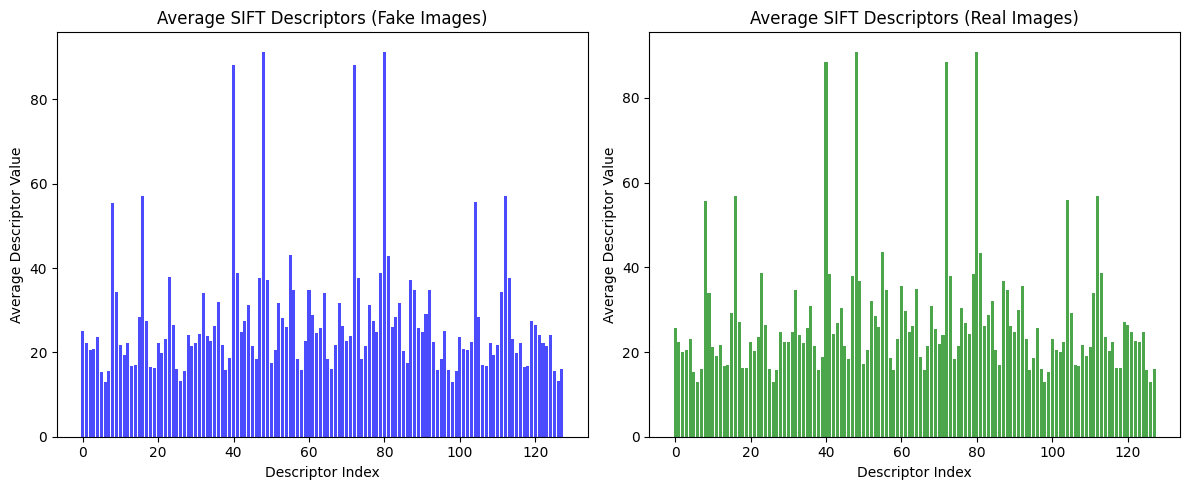

In [13]:
def compute_sift_features(images):
    # Compute SIFT features for a list of images and return keypoints and descriptors.
    sift = cv2.SIFT_create()
    all_descriptors = []
    
    for image in images:
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute SIFT keypoints and descriptors
        keypoints, descriptors = sift.detectAndCompute(gray_image, None)
        
        if descriptors is not None:
            all_descriptors.append(descriptors)
    
    return all_descriptors

def average_sift_descriptors(sift_descriptors):
    # Average SIFT descriptors across all images.
    # Concatenate all descriptors vertically and compute the mean
    if sift_descriptors:
        concatenated_descriptors = np.vstack(sift_descriptors)
        avg_descriptor = np.mean(concatenated_descriptors, axis=0)
        return avg_descriptor
    else:
        return None
    
def compute_sift_stats(sift_descriptors):
    # Compute statistics (mean and std) for SIFT descriptors.
    if not sift_descriptors:
        return {'Mean Descriptor Magnitude': 0, 'Std Descriptor Magnitude': 0, 'Keypoints Count': 0}
    
    magnitudes = []
    keypoint_counts = []

    for descriptors in sift_descriptors:
        magnitudes.append(np.linalg.norm(descriptors, axis=1).mean())  # Mean of descriptor magnitudes
        keypoint_counts.append(descriptors.shape[0])  # Count of keypoints

    return {
        'Mean Descriptor Magnitude': np.mean(magnitudes),
        'Std Descriptor Magnitude': np.std(magnitudes),
        'Keypoints Count': np.mean(keypoint_counts)
    }

def display_sift_stats_table(fake_features, real_features):
    # Create a comparison table for SIFT statistics.
    fake_stats = compute_sift_stats(fake_features)
    real_stats = compute_sift_stats(real_features)

    # Create a DataFrame to display the statistics
    comparison_table = pd.DataFrame({
        'Metric': ['Mean Descriptor Magnitude', 'Std Descriptor Magnitude', 'Keypoints Count'],
        'Fake': [fake_stats['Mean Descriptor Magnitude'], fake_stats['Std Descriptor Magnitude'], fake_stats['Keypoints Count']],
        'Real': [real_stats['Mean Descriptor Magnitude'], real_stats['Std Descriptor Magnitude'], real_stats['Keypoints Count']]
    })

    # Display the table
    display(comparison_table.style.set_caption("SIFT Statistics Comparison").set_properties(**{'text-align': 'center'}))


def plot_sift_descriptors(avg_sift_fake, avg_sift_real):
    #Plot average SIFT descriptors for comparison.
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].bar(range(len(avg_sift_fake)), avg_sift_fake, color='blue', alpha=0.7)
    ax[0].set_title('Average SIFT Descriptors (Fake Images)')
    ax[0].set_xlabel('Descriptor Index')
    ax[0].set_ylabel('Average Descriptor Value')
    
    ax[1].bar(range(len(avg_sift_real)), avg_sift_real, color='green', alpha=0.7)
    ax[1].set_title('Average SIFT Descriptors (Real Images)')
    ax[1].set_xlabel('Descriptor Index')
    ax[1].set_ylabel('Average Descriptor Value')
    
    plt.tight_layout()
    plt.show()

# Compute SIFT features for fake and real images
sift_features_fake = compute_sift_features(fake_images)
sift_features_real = compute_sift_features(real_images)

# Average the SIFT descriptors
avg_sift_fake = average_sift_descriptors(sift_features_fake)
avg_sift_real = average_sift_descriptors(sift_features_real)

# Display the SIFT stats table
display_sift_stats_table(sift_features_fake, sift_features_real)

# Check if descriptors were computed and plot them
if avg_sift_fake is not None and avg_sift_real is not None:
    plot_sift_descriptors(avg_sift_fake, avg_sift_real)
else:
    print("No descriptors computed for fake or real images.")


**Local Binary Patterns (LBP)**

,Metric,Fake,Real
0,Mean,0.100000,0.100000
1,Standard Deviation,0.039607,0.042730
2,Entropy,2.223300,2.208041


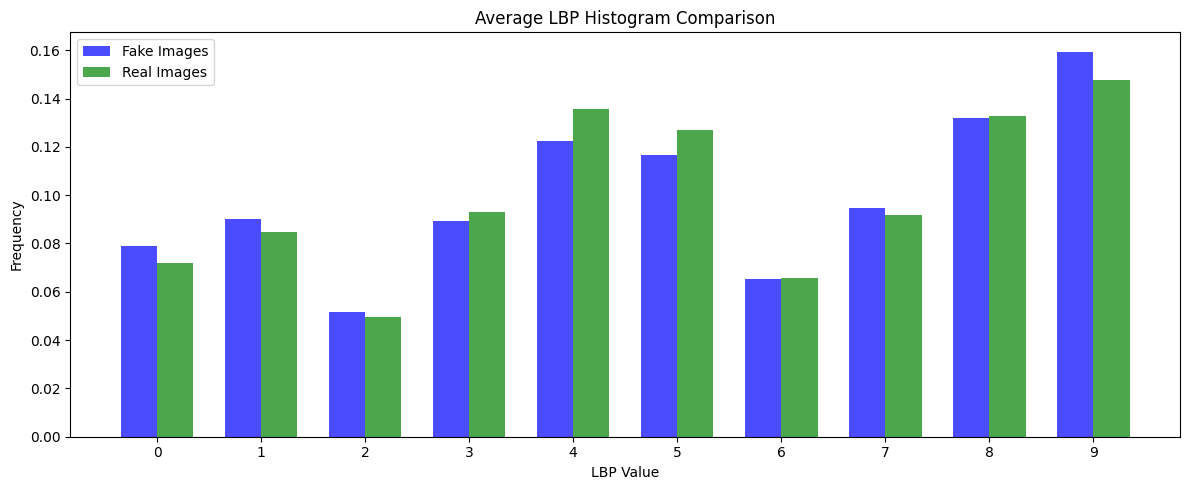

In [14]:
def compute_lbp_features(images, P=8, R=1):
    #Compute LBP features for a list of images.
    lbp_features = []
    
    for image in images:
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Compute LBP
        lbp = local_binary_pattern(gray_image, P, R, method="uniform")
        
        # Compute the histogram of the LBP
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
        
        # Normalize the histogram
        hist = hist.astype("float")
        hist /= hist.sum()
        
        lbp_features.append(hist)
    
    return lbp_features

def average_lbp_histograms(lbp_histograms):
    #Average LBP histograms across all images.
    if lbp_histograms:
        avg_hist = np.mean(lbp_histograms, axis=0)
        return avg_hist
    else:
        return None

def compute_lbp_stats(fake_histograms, real_histograms):
    # Compute mean, standard deviation, and entropy for a set of LBP histograms.
    stats = {'Metric': ['Mean', 'Standard Deviation', 'Entropy']}
    means_fake, std_devs_fake, entropies_fake = [], [], []

    for hist in fake_histograms:
        means_fake.append(np.mean(hist))
        std_devs_fake.append(np.std(hist))
        entropies_fake.append(entropy(hist))

    # Calculate statistics for fake images
    stats['Fake'] = [np.mean(means_fake), np.mean(std_devs_fake), np.mean(entropies_fake)]

    # Calculate statistics for real images
    means_real, std_devs_real, entropies_real = [], [], []
    for hist in real_histograms:
        means_real.append(np.mean(hist))
        std_devs_real.append(np.std(hist))
        entropies_real.append(entropy(hist))

    # Assign real statistics
    stats['Real'] = [np.mean(means_real), np.mean(std_devs_real), np.mean(entropies_real)]

    return pd.DataFrame(stats)

def display_lbp_stats_table(fake_features, real_features):
    # Display LBP statistics in a comparison table.
    # Pass both fake and real features to compute_lbp_stats
    stats = compute_lbp_stats(fake_features, real_features)

    # Display the table
    display(stats.style.set_caption("LBP Statistics Comparison").set_properties(**{'text-align': 'center'}))
    
def plot_lbp_histograms(avg_lbp_fake, avg_lbp_real):
    #Plot average LBP histograms side by side in one plot.
    x = np.arange(len(avg_lbp_fake))  # X values for histogram bins

    width = 0.35  # Width of the bars
    fig, ax = plt.subplots(figsize=(12, 5))

    # Plotting bars for average LBP histograms
    ax.bar(x - width/2, avg_lbp_fake, width, label='Fake Images', color='blue', alpha=0.7)
    ax.bar(x + width/2, avg_lbp_real, width, label='Real Images', color='green', alpha=0.7)

    # Adding labels and title
    ax.set_title('Average LBP Histogram Comparison')
    ax.set_xlabel('LBP Value')
    ax.set_ylabel('Frequency')
    ax.set_xticks(x)
    ax.set_xticklabels(x)
    ax.legend()

    plt.tight_layout()
    plt.show()


# Compute LBP features for fake and real images
lbp_features_fake = compute_lbp_features(fake_images)
lbp_features_real = compute_lbp_features(real_images)

# Average the LBP histograms
avg_lbp_fake = average_lbp_histograms(lbp_features_fake)
avg_lbp_real = average_lbp_histograms(lbp_features_real)

# Display the LBP stats table
display_lbp_stats_table(lbp_features_fake, lbp_features_real)

# Plot the average LBP histograms
if avg_lbp_fake is not None and avg_lbp_real is not None:
    plot_lbp_histograms(avg_lbp_fake, avg_lbp_real)
else:
    print("No LBP histograms computed for fake or real images.")


**Wavelet Transform**

,Component,Fake Mean,Fake Std Dev,Fake Energy,Real Mean,Real Std Dev,Real Energy
0,LL,217.258950,105.645161,355511801.685487,191.364356,104.625551,293575042.446569
1,LH,0.213866,19.922162,2461074.580275,0.204282,19.564927,2397108.676712
2,HL,0.032531,21.992330,3091250.239459,0.007832,20.772705,2771438.980143
3,HH,-0.002340,12.474977,1008391.490289,-0.000075,12.052418,943916.713423


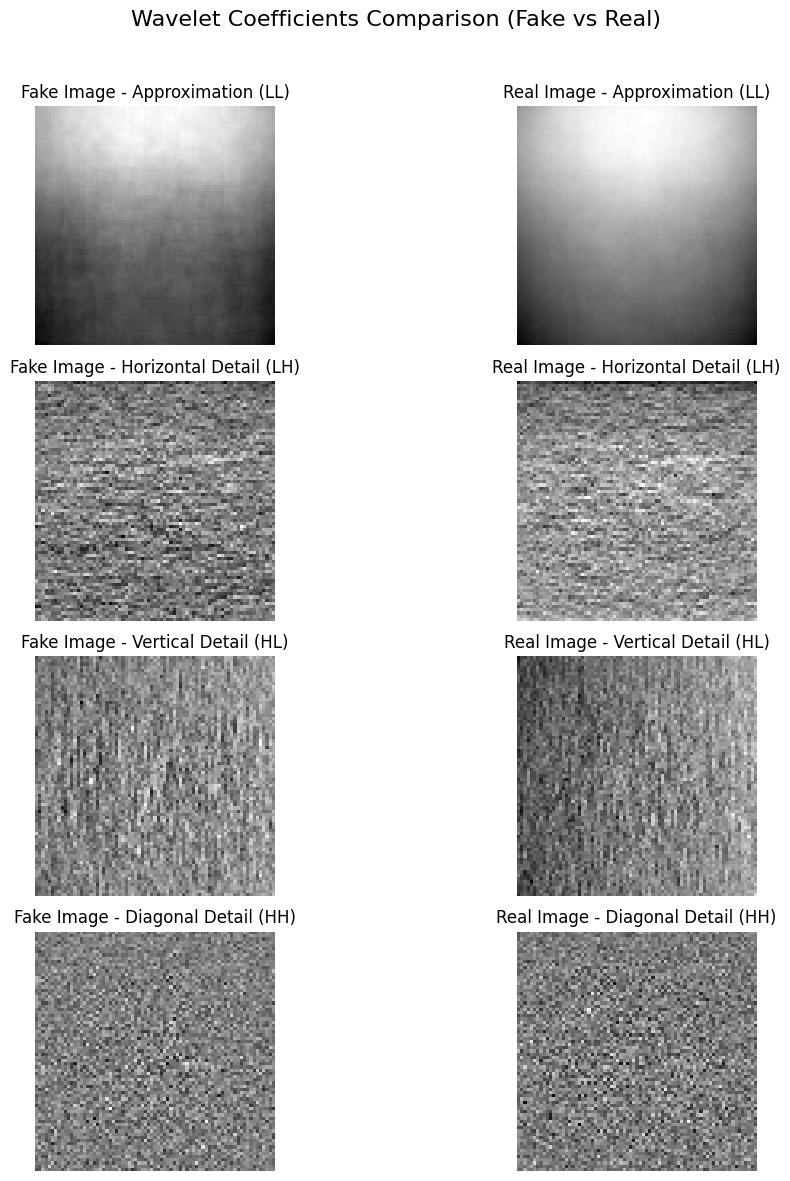

In [15]:
def compute_wavelet_features(images, wavelet='haar'):
    #Compute wavelet features for a list of images.
    wavelet_features = []
    
    for image in images:
        # Convert to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Perform 2D discrete wavelet transform
        coeffs2 = pywt.dwt2(gray_image, wavelet)
        
        # Extract the approximation and details
        LL, (LH, HL, HH) = coeffs2
        
        # Append the coefficients to the list
        wavelet_features.append((LL, LH, HL, HH))
    
    return wavelet_features

def compute_wavelet_stats(wavelet_features):
    #Compute mean, standard deviation, and energy of wavelet coefficients.
    stats = {'Component': ['LL', 'LH', 'HL', 'HH'], 
             'Mean': [], 'Std Dev': [], 'Energy': []}
    
    for i in range(4):  # LL, LH, HL, HH
        coeffs = [feat[i] for feat in wavelet_features]
        mean_val = np.mean([np.mean(c) for c in coeffs])
        std_val = np.mean([np.std(c) for c in coeffs])
        energy = np.mean([np.sum(np.square(c)) for c in coeffs])

        stats['Mean'].append(mean_val)
        stats['Std Dev'].append(std_val)
        stats['Energy'].append(energy)

    return pd.DataFrame(stats)

def display_wavelet_stats(wavelet_features_fake, wavelet_features_real):
    #Display a table comparing wavelet stats for fake and real images.
    fake_stats = compute_wavelet_stats(wavelet_features_fake)
    real_stats = compute_wavelet_stats(wavelet_features_real)

    # Merge the two DataFrames for side-by-side comparison
    comparison_table = pd.concat([fake_stats, real_stats[['Mean', 'Std Dev', 'Energy']]], axis=1)
    comparison_table.columns = ['Component', 'Fake Mean', 'Fake Std Dev', 'Fake Energy',
                                'Real Mean', 'Real Std Dev', 'Real Energy']

    # Display the table
    display(comparison_table.style.set_caption("Wavelet Coefficients Statistics Comparison")
            .set_properties(**{'text-align': 'center'}))
    
def plot_wavelet_comparison(wavelet_features_fake, wavelet_features_real):
    #Plot wavelet coefficients for fake and real images side by side.
    titles = ['Approximation (LL)', 'Horizontal Detail (LH)', 'Vertical Detail (HL)', 'Diagonal Detail (HH)']
    
    fig, axs = plt.subplots(4, 2, figsize=(12, 12))
    
    for i in range(4):
        # Fake coefficients
        axs[i, 0].imshow(np.mean([feat[i] for feat in wavelet_features_fake], axis=0), cmap='gray')
        axs[i, 0].set_title(f'Fake Image - {titles[i]}')
        axs[i, 0].axis('off')
        
        # Real coefficients
        axs[i, 1].imshow(np.mean([feat[i] for feat in wavelet_features_real], axis=0), cmap='gray')
        axs[i, 1].set_title(f'Real Image - {titles[i]}')
        axs[i, 1].axis('off')
    
    plt.suptitle('Wavelet Coefficients Comparison (Fake vs Real)', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()

# Compute wavelet features for fake and real images
wavelet_features_fake = compute_wavelet_features(fake_images)
wavelet_features_real = compute_wavelet_features(real_images)

# Display the wavelet stats table
display_wavelet_stats(wavelet_features_fake, wavelet_features_real)

# Plot the wavelet coefficients
plot_wavelet_comparison(wavelet_features_fake, wavelet_features_real)


**Color Histogram Analysis**

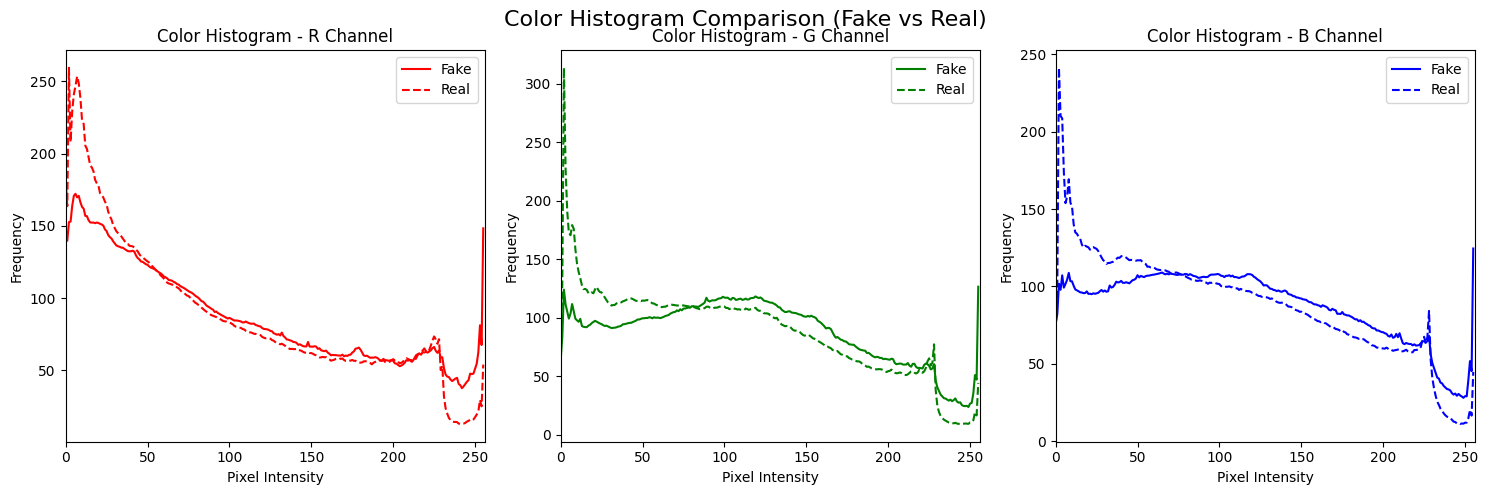

,Channel,Fake Mean,Fake Std Dev,Real Mean,Real Std Dev
0,Blue,87.890625,92.771339,87.890625,103.985802
1,Green,87.890625,98.272949,87.890625,109.396225
2,Red,87.890625,111.150238,87.890625,118.818634


In [16]:
def compute_color_histogram(image):
    #Compute the color histogram for an image.
    color_hist = {}
    colors = ('b', 'g', 'r')  # OpenCV uses BGR format

    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        color_hist[color] = hist

    return color_hist

def compute_histogram_stats(histograms):
    """Compute summary statistics for color histograms."""
    stats = {'Channel': ['Blue', 'Green', 'Red'], 'Mean': [], 'Std Dev': []}
    for color in ('b', 'g', 'r'):
        # Calculate mean and standard deviation for each color channel
        mean_vals = [np.mean(hist[color]) for hist in histograms]
        std_vals = [np.std(hist[color]) for hist in histograms]

        stats['Mean'].append(np.mean(mean_vals))
        stats['Std Dev'].append(np.mean(std_vals))

    return pd.DataFrame(stats)

def plot_color_histograms(histograms_fake, histograms_real):
    #Plot color histograms for fake and real images side by side.
    colors = ['r', 'g', 'b']  # Red, Green, Blue
    titles = ['Fake Images', 'Real Images']
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, color in enumerate(colors):
        # Average histogram for fake images
        avg_hist_fake = np.mean([histograms_fake[j][color] for j in range(len(histograms_fake))], axis=0)
        axs[i].plot(avg_hist_fake, color=color, label='Fake')
        
        # Average histogram for real images
        avg_hist_real = np.mean([histograms_real[j][color] for j in range(len(histograms_real))], axis=0)
        axs[i].plot(avg_hist_real, color=color, linestyle='dashed', label='Real')

        axs[i].set_xlim([0, 256])
        axs[i].set_title(f'Color Histogram - {color.upper()} Channel')
        axs[i].set_xlabel('Pixel Intensity')
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
    
    plt.suptitle('Color Histogram Comparison (Fake vs Real)', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust title position
    plt.show()
    
def display_histogram_stats(fake_images, real_images):
    #Compute and display histogram statistics as a comparison table.
    histograms_fake = [compute_color_histogram(img) for img in fake_images]
    histograms_real = [compute_color_histogram(img) for img in real_images]

    # Compute stats for fake and real images
    fake_stats = compute_histogram_stats(histograms_fake)
    real_stats = compute_histogram_stats(histograms_real)

    # Merge the two DataFrames for side-by-side comparison
    comparison_table = pd.concat([fake_stats, real_stats[['Mean', 'Std Dev']]], axis=1)
    comparison_table.columns = ['Channel', 'Fake Mean', 'Fake Std Dev', 'Real Mean', 'Real Std Dev']

    # Display the table
    display(comparison_table.style.set_caption("Color Histogram Statistics Comparison")
            .set_properties(**{'text-align': 'center'}))

# Compute and plot histograms
histograms_fake = [compute_color_histogram(img) for img in fake_images]
histograms_real = [compute_color_histogram(img) for img in real_images]

plot_color_histograms(histograms_fake, histograms_real)
display_histogram_stats(fake_images, real_images)


**Principal Component Analysis (PCA)**

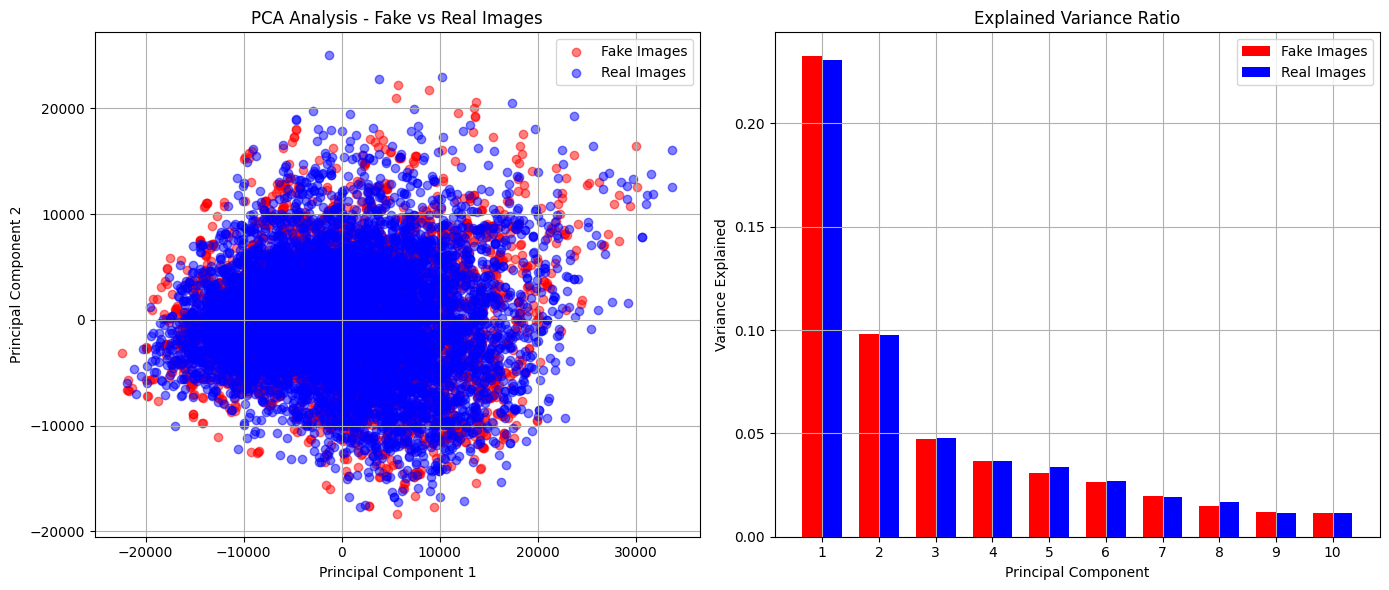

Principal Component,Fake Images,Real Images
1,0.232487,0.230497
2,0.098352,0.097660
3,0.047206,0.047638
4,0.036573,0.036810
5,0.030976,0.033818
6,0.026382,0.026991
7,0.019614,0.019178
8,0.014666,0.016593
9,0.012118,0.011517
10,0.011374,0.011317


In [17]:
def compute_pca(images, n_components=10):
    #Compute PCA on the provided images and return explained variance.
    # Reshape the images to a 2D array (n_samples, n_features)
    reshaped_images = np.array([img.flatten() for img in images])
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(reshaped_images)
    
    return pca_result, pca.explained_variance_ratio_

def plot_pca_comparison(pca_fake, pca_real, var_fake, var_real):
    #Plot PCA results and explained variance for fake and real images.
    plt.figure(figsize=(14, 6))

    # Scatter plot of the first two principal components
    plt.subplot(1, 2, 1)
    plt.scatter(pca_fake[:, 0], pca_fake[:, 1], label='Fake Images', color='red', alpha=0.5)
    plt.scatter(pca_real[:, 0], pca_real[:, 1], label='Real Images', color='blue', alpha=0.5)
    plt.title('PCA Analysis - Fake vs Real Images')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid()

    # Bar plot of explained variance
    plt.subplot(1, 2, 2)
    components = np.arange(1, len(var_fake) + 1)
    width = 0.35  # Width of the bars
    plt.bar(components - width/2, var_fake, width, label='Fake Images', color='red')
    plt.bar(components + width/2, var_real, width, label='Real Images', color='blue')
    plt.title('Explained Variance Ratio')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.xticks(components)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

def create_pca_comparison_table(var_fake, var_real, n_components=10):
    #Create a comparison table for explained variance.
    # Select the first n components for the table
    components = np.arange(1, n_components + 1)

    # Create a DataFrame for the comparison
    data = {
        'Principal Component': components,
        'Fake Images': var_fake[:n_components],
        'Real Images': var_real[:n_components]
    }
    df = pd.DataFrame(data)

    # Display the table with styling
    styled_df = df.style.set_caption("Explained Variance Ratio Comparison") \
        .highlight_max(color='lightgreen', subset=['Fake Images', 'Real Images']) \
        .set_properties(**{'text-align': 'center'})\
        .hide(axis='index')
    
    display(styled_df)

# Compute PCA for fake and real images
pca_fake, var_fake = compute_pca(fake_images)
pca_real, var_real = compute_pca(real_images)

# Plot the PCA comparison and explained variance
plot_pca_comparison(pca_fake, pca_real, var_fake, var_real)

# Create the comparison table for the first 10 components
create_pca_comparison_table(var_fake, var_real)

**image edge feature**

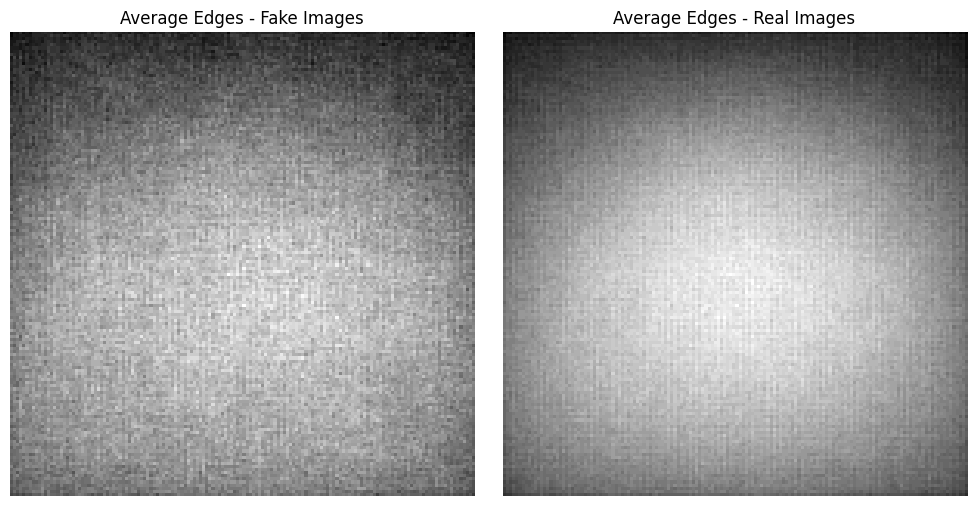

,Metric,Fake Images,Real Images
0,Edge Density (%),17.373652,16.779065
1,Mean Edge Intensity,44.302812,42.786616
2,Std Edge Intensity,93.338697,91.762722
3,Connected Components,146.566270,139.970765


In [18]:
def compute_edges(image):
    #Compute edges using the Canny edge detection.
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray_image, 100, 200)
    return edges

def average_edges(images):
    #Compute the average edges for a list of images.
    total_edges = np.zeros_like(compute_edges(images[0]), dtype=np.float32)

    for image in images:
        edges = compute_edges(image)
        total_edges += edges

    # Normalize the accumulated edges to [0, 255]
    avg_edges = (total_edges / len(images)).astype(np.uint8)
    return avg_edges

def plot_average_edges(fake_images, real_images):
    #Plot the average edge images for fake and real datasets side by side.
    avg_fake_edges = average_edges(fake_images)
    avg_real_edges = average_edges(real_images)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(avg_fake_edges, cmap='gray')
    plt.title('Average Edges - Fake Images')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(avg_real_edges, cmap='gray')
    plt.title('Average Edges - Real Images')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def compute_edge_metrics(images):
    #Compute edge metrics for a list of images.
    total_pixels = images[0].shape[0] * images[0].shape[1]  # Total number of pixels per image
    
    edge_density_list = []
    mean_intensity_list = []
    std_intensity_list = []
    connected_components_list = []

    for image in images:
        edges = compute_edges(image)
        
        # Metrics calculation
        edge_pixels = np.count_nonzero(edges)
        edge_density = edge_pixels / total_pixels * 100  # Percentage of edge pixels
        
        mean_intensity = np.mean(edges)
        std_intensity = np.std(edges)
        
        # Connected components (count distinct edge regions)
        connected_components = skimage.measure.label(edges, connectivity=2).max()

        # Store metrics
        edge_density_list.append(edge_density)
        mean_intensity_list.append(mean_intensity)
        std_intensity_list.append(std_intensity)
        connected_components_list.append(connected_components)

    # Create a DataFrame with the metrics
    metrics_df = pd.DataFrame({
        "Edge Density (%)": edge_density_list,
        "Mean Edge Intensity": mean_intensity_list,
        "Std Edge Intensity": std_intensity_list,
        "Connected Components": connected_components_list
    })

    return metrics_df.mean()  # Return the average of all metrics

def create_edge_metrics_table(fake_images, real_images):
    #Create a nicely formatted comparison table for edge metrics.
    # Compute metrics for both datasets
    fake_metrics = compute_edge_metrics(fake_images)
    real_metrics = compute_edge_metrics(real_images)

    # Combine into a DataFrame for comparison
    comparison_df = pd.DataFrame({
        "Metric": fake_metrics.index,
        "Fake Images": fake_metrics.values,
        "Real Images": real_metrics.values
    })

    # Style the DataFrame for nicer display in Jupyter
    styled_df = comparison_df.style.highlight_min(
        subset=["Fake Images", "Real Images"], color='lightcoral'
    ).highlight_max(
        subset=["Fake Images", "Real Images"], color='lightgreen'
    ).set_properties(**{'text-align': 'center'}).set_caption(
        "Comparison of Edge Metrics between Fake and Real Images"
    )

    display(styled_df)  # Display the styled DataFrame

# Call the function to plot average edges comparison
plot_average_edges(fake_images, real_images)

# Call the function to display the metrics comparison table
create_edge_metrics_table(fake_images, real_images)

**GLCM (Gray Level Co-occurrence Matrix)**

,Fake Images,Real Images
Contrast,0.064378,0.053264
Dissimilarity,0.163236,0.142400
Homogeneity,0.221427,0.265364
Energy,0.033041,0.042540
Correlation,0.858346,0.879920
ASM,0.003786,0.006552


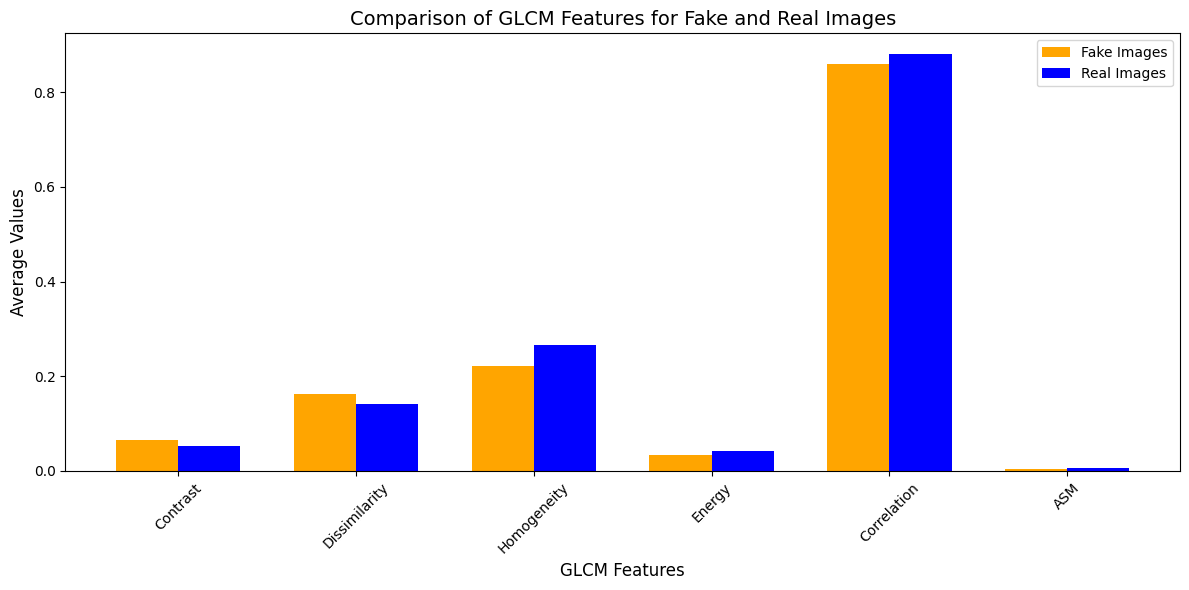

In [10]:
def compute_glcm_features(image):
    #Compute GLCM features for the given image.
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define distances and angles for GLCM
    distances = [1]
    angles = [0]  # You can use more angles (e.g., np.pi/4, np.pi/2)

    # Compute GLCM
    glcm = graycomatrix(gray_image, distances, angles, symmetric=True, normed=True)

    # Extract GLCM properties
    features = {
        'Contrast': graycoprops(glcm, 'contrast')[0, 0],
        'Dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'Homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'Energy': graycoprops(glcm, 'energy')[0, 0],
        'Correlation': graycoprops(glcm, 'correlation')[0, 0],
        'ASM': graycoprops(glcm, 'ASM')[0, 0],
    }
    return features

def rescale_features(fake_features_list, real_features_list):
    # Combine all feature data for scaling
    all_features = pd.DataFrame(fake_features_list + real_features_list)

    # Apply Min-Max Scaling
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(all_features)

    # Split scaled data back into fake and real
    num_fake = len(fake_features_list)
    scaled_fake = pd.DataFrame(scaled_features[:num_fake], columns=all_features.columns)
    scaled_real = pd.DataFrame(scaled_features[num_fake:], columns=all_features.columns)

    return scaled_fake, scaled_real


def plot_glcm_comparison(fake_images, real_images):
    #Create a comparison table of GLCM features for fake and real images.
    num_images = min(len(fake_images), len(real_images))

    # Store GLCM features for all fake and real images
    fake_features_list = [compute_glcm_features(img) for img in fake_images[:num_images]]
    real_features_list = [compute_glcm_features(img) for img in real_images[:num_images]]
    
    scaled_fake_df, scaled_real_df = rescale_features(fake_features_list, real_features_list)

    # Compute mean of scaled features
    fake_mean = scaled_fake_df.mean().to_frame(name='Fake Images')
    real_mean = scaled_real_df.mean().to_frame(name='Real Images')

    # Combine the DataFrames for easy comparison
    comparison_df = pd.concat([fake_mean, real_mean], axis=1)

    # Convert features into DataFrames for easier concatenation
#     fake_df = pd.DataFrame(fake_features_list).mean().to_frame(name='Fake Images')
#     real_df = pd.DataFrame(real_features_list).mean().to_frame(name='Real Images')

    # Combine the DataFrames for side-by-side comparison
#     comparison_df = pd.concat([fake_df, real_df], axis=1)

    # Display the comparison table with styled formatting
    styled_df = comparison_df.style.set_caption("GLCM Feature Comparison") \
        .highlight_min(color='lightcoral') \
        .highlight_max(color='lightgreen') \
        .set_properties(**{'text-align': 'center'})
    
    display(styled_df)  # Use IPython display for better output in Jupyter
    
    # Plot bar charts for each GLCM feature
    features = comparison_df.index.tolist()
    fake_values = comparison_df['Fake Images'].values
    real_values = comparison_df['Real Images'].values
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    index = range(len(features))

    # Bar chart
    plt.bar(index, fake_values, bar_width, label='Fake Images', color='orange')
    plt.bar([i + bar_width for i in index], real_values, bar_width, label='Real Images', color='blue')

    # Add feature names as x-axis labels
    plt.xlabel('GLCM Features', fontsize=12)
    plt.ylabel('Average Values', fontsize=12)
    plt.title('Comparison of GLCM Features for Fake and Real Images', fontsize=14)
    plt.xticks([i + bar_width / 2 for i in index], features, rotation=45)
    plt.legend()
    plt.tight_layout()

    plt.show()

# Call the function to compare GLCM features
plot_glcm_comparison(fake_images, real_images)


,Fake Images,Real Images
Mean ELA,17.021351,21.008386
Std ELA,12.825099,16.195389


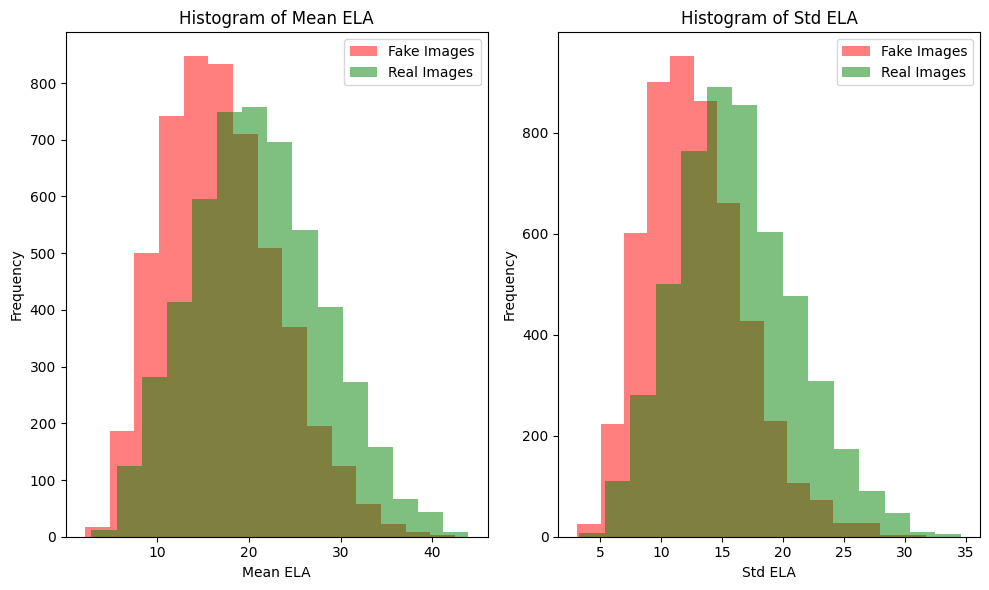

In [20]:
def compute_ela_features(image, quality=90):
    # Convert BGR image to RGB for Pillow
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # Save image with JPEG compression (in-memory simulation)
    compressed_image = 'temp_compressed.jpg'
    pil_image.save(compressed_image, 'JPEG', quality=quality)

    # Open the compressed image
    compressed_pil = Image.open(compressed_image)

    # Compute the difference between original and compressed images
    ela_image = ImageChops.difference(pil_image, compressed_pil)

    # Get the minimum and maximum pixel values in the ELA image
    band_values = ela_image.getextrema()
    max_value = max([val[1] for val in band_values])

    # If the maximum value is 0, set it to 1 to avoid division by zero
    if max_value == 0:
        max_value = 1

    # Scale the pixel values of the ELA image to the range [0, 255]
    scale = 255.0 / max_value
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)

    # Convert ELA image to grayscale and to numpy array
    ela_array = np.array(ela_image.convert('L'))

    # Compute basic statistics from the ELA image
    mean_ela = np.mean(ela_array)
    std_ela = np.std(ela_array)
    compressed_pil.close()
    os.remove(compressed_image)

    # Return the ELA features as a dictionary
    return {'Mean ELA': mean_ela, 'Std ELA': std_ela}

def plot_ela_comparison(fake_images, real_images):
    # Create a comparison table of ELA features for fake and real images
    num_images = min(len(fake_images), len(real_images))

    # Store ELA features for all fake and real images
    fake_features_list = [compute_ela_features(img) for img in fake_images[:num_images]]
    real_features_list = [compute_ela_features(img) for img in real_images[:num_images]]

    # Convert features into DataFrames for easier concatenation
    fake_df = pd.DataFrame(fake_features_list)
    real_df = pd.DataFrame(real_features_list)

    # Combine the DataFrames for side-by-side comparison
    comparison_df = pd.concat([fake_df.mean().to_frame(name='Fake Images'),
                               real_df.mean().to_frame(name='Real Images')], axis=1)

    # Display the comparison table with styled formatting
    styled_df = comparison_df.style.set_caption("ELA Feature Comparison") \
        .highlight_min(color='lightcoral') \
        .highlight_max(color='lightgreen') \
        .set_properties(**{'text-align': 'center'})
    
    display(styled_df)  # Use IPython display for better output in Jupyter

    # Plot the comparison of mean and std ELA values for fake vs real images
    plt.figure(figsize=(10, 6))

    # Plot Mean ELA
    plt.subplot(1, 2, 1)
    plt.hist(fake_df['Mean ELA'], alpha=0.5, label='Fake Images', color='red', bins=15)
    plt.hist(real_df['Mean ELA'], alpha=0.5, label='Real Images', color='green', bins=15)
    plt.title('Histogram of Mean ELA')
    plt.xlabel('Mean ELA')
    plt.ylabel('Frequency')
    plt.legend()

    # Plot Std ELA
    plt.subplot(1, 2, 2)
    plt.hist(fake_df['Std ELA'], alpha=0.5, label='Fake Images', color='red', bins=15)
    plt.hist(real_df['Std ELA'], alpha=0.5, label='Real Images', color='green', bins=15)
    plt.title('Histogram of Std ELA')
    plt.xlabel('Std ELA')
    plt.ylabel('Frequency')
    plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

# Example usage: plot ELA feature comparison
plot_ela_comparison(fake_images, real_images)


## Preprocessing

**Extract Features**

In [4]:
def extract_canny_edges(gray_image):
    # Compute Canny edges for an input image.
    edges = cv2.Canny(gray_image, 100, 200)  # Apply Canny edge detection
    return csr_matrix(edges.flatten())  # Flatten the edge map to a 1D feature vector

def extract_glcm_features(gray_image):
    glcm = graycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    Dissimilarity= graycoprops(glcm, 'dissimilarity')[0, 0]
    Energy= graycoprops(glcm, 'energy')[0, 0]
    Correlation = graycoprops(glcm, 'correlation')[0, 0]
    ASM = graycoprops(glcm, 'ASM')[0, 0]
    return csr_matrix(np.array([contrast, homogeneity,Dissimilarity,Energy,Correlation,ASM]))


def extract_wavelet_features(gray_image, wavelet='haar'):
    # Perform 2D discrete wavelet transform
    coeffs2 = pywt.dwt2(gray_image, wavelet)
    LL, (LH, HL, HH) = coeffs2

    # Compute mean, variance, and energy for each coefficient matrix
    feature_vector = np.hstack([
        LL.mean(), LL.var(),  # LL component
        LH.mean(), LH.var(),  # LH component
        HL.mean(), HL.var(),  # HL component
        HH.mean(), HH.var()   # HH component
    ])

    # Convert the feature vector to a sparse matrix
    return csr_matrix(feature_vector)


def compute_color_histogram(image):
    # Compute the color histogram for an image.
    hist_vector = []

    # Compute histograms for each color channel (BGR)
    colors = ('b', 'g', 'r')  
    for i, color in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256]).flatten()
        hist_vector.extend(hist)

    # Convert to sparse matrix
    return csr_matrix(hist_vector)

def compute_sift_features(gray_image):
    # Compute SIFT features and return a fixed-length vector (mean-pooled)."""
    sift = cv2.SIFT_create()
#     gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray_image, None)

    # If no descriptors are found, return a zero vector
    if descriptors is None:
        return csr_matrix(np.zeros((1, 128)))

    # Compute the mean descriptor to get a fixed-length vector
    mean_descriptor = descriptors.mean(axis=0)
    return csr_matrix(mean_descriptor)


def compute_ela_features(image, quality=90):
    
    # Convert BGR image to RGB for Pillow
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pil_image = Image.fromarray(image_rgb)

    # Save image with JPEG compression
    compressed_image = 'temp_compressed.jpg'
    pil_image.save(compressed_image, 'JPEG', quality=quality)

    # Open the compressed image
    compressed_pil = Image.open(compressed_image)

    # Compute the difference between original and compressed images
    ela_image = ImageChops.difference(pil_image, compressed_pil)
    
    # Get the minimum and maximum pixel values in the ELA image
    band_values = ela_image.getextrema()
    max_value = max([val[1] for val in band_values])

    # If the maximum value is 0, set it to 1 to avoid division by zero
    if max_value == 0:
        max_value = 1

    # Scale the pixel values of the ELA image to the range [0, 255]
    scale = 255.0 / max_value
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)


    # Convert ELA image to grayscale and to numpy array
    ela_array = np.array(ela_image.convert('L'))

    # Compute basic statistics from the ELA image
    mean_ela = np.mean(ela_array)
    std_ela = np.std(ela_array)
    compressed_pil.close()
    os.remove(compressed_image)

    # Return the ELA features as a sparse matrix
    return csr_matrix(np.array([mean_ela, std_ela]))


def extract_features(images, feature_list):
    features = []  # Store each image's feature as a sparse matrix

    for img in images:
        feature_list_sparse = []  # Collect sparse or dense features for this image

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        if 'hog_features' in feature_list:
            hog_features = hog(
                gray, pixels_per_cell=(8, 8), cells_per_block=(3, 3),
                orientations=12, block_norm='L2-Hys', visualize=False
            )
            feature_list_sparse.append(csr_matrix(hog_features))

        if 'lbp_features' in feature_list:
            lbp_features = local_binary_pattern(gray, P=16, R=1, method='uniform').flatten()
            feature_list_sparse.append(csr_matrix(lbp_features))

        if 'glcm_features' in feature_list:
            glcm_features = extract_glcm_features(gray)
            feature_list_sparse.append(glcm_features)

        if 'wavelet_features' in feature_list:
            wavelet_features = extract_wavelet_features(gray)
            feature_list_sparse.append(wavelet_features)

        if 'edge_features' in feature_list:
            edge_features = extract_canny_edges(gray)  # Already a csr_matrix
            feature_list_sparse.append(edge_features)
            
        if 'color_histogram' in feature_list:
            color_hist_features = compute_color_histogram(img)
            feature_list_sparse.append(color_hist_features)
            
        if 'sift_features' in feature_list:
            sift_features = compute_sift_features(gray)
            feature_list_sparse.append(sift_features)
            
        if 'ela_features' in feature_list:
            ela_features = compute_ela_features(img)
            feature_list_sparse.append(ela_features)

        # Stack sparse features horizontally for each image
        combined_features = hstack(feature_list_sparse)
        features.append(combined_features)

    # Stack all images' features vertically
    return vstack(features)


#Extract features and ensure sparse representation
X = extract_features(images, ['ela_features' ,'wavelet_features','glcm_features','color_histogram','edge_features'])#\
                             # ,'sift_features','hog_features','lbp_features'])
print(f"X shape: {X.shape}, X type: {type(X)}") 


X shape: (12614, 23284), X type: <class 'scipy.sparse._csr.csr_matrix'>


**Preparing the train and test set** 

In [5]:
# Split the Data into Train and Test Sets 
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, stratify=labels, random_state=42)
if isinstance(X_train, csr_matrix):
    X_train = X_train.toarray()
    X_test = X_test.toarray()
    

**Taking care of unbalanced data**

In [6]:
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

**Take care of outlier and scaling the data**

In [7]:
# Scale the Features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

**Applying different type of dimension reduction**

In [8]:
# Reduce dimensionality to 50 features with LLE
lle = LocallyLinearEmbedding(n_components=3000, n_neighbors=10)
X_train_lle_3000 = lle.fit_transform(X_train_scaled)
X_test_lle_3000 = lle.transform(X_test_scaled)


In [173]:
#joblib.dump(scaler,'scaling.pkl')

['scaling.pkl']

In [ ]:
#joblib.dump(lle,'lle.pkl')

In [5]:
# X_train_lle_3000,X_test_lle_3000=joblib.load("Train_test_lle.pkl")

In [6]:
# X_train_balanced, y_train_balanced=joblib.load("Train_balanaced.pkl")

In [7]:
# X_test, y_test=joblib.load("Test_features_lables.pkl")

----------------------------------------------------
# Create Models

**Logistic Reggression**

In [9]:
# Define the Logistic Regression model
log_reg = LogisticRegression(max_iter=10000,warm_start=True,n_jobs=-1, solver='saga',C=10, penalty='l1')

# Fit GridSearchCV on the training data
log_reg.fit(X_train_lle_3000, y_train_balanced)

y_log = log_reg.predict(X_test_lle_3000)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_log))
print("Classification Report:\n", classification_report(y_test, y_log))

Accuracy: 0.730875941339675
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78      1498
           1       0.69      0.61      0.65      1025

    accuracy                           0.73      2523
   macro avg       0.72      0.71      0.72      2523
weighted avg       0.73      0.73      0.73      2523



In [10]:
precision_logistic = precision_score(y_test, y_log)
recall_logistic = recall_score(y_test, y_log)
f1_logistic = f1_score(y_test, y_log)
print(f"Precision: {precision_logistic:.4f}")
print(f"Recall: {recall_logistic:.4f}")
print(f"F1-Score: {f1_logistic:.4f}")

Precision: 0.6893
Recall: 0.6146
F1-Score: 0.6498


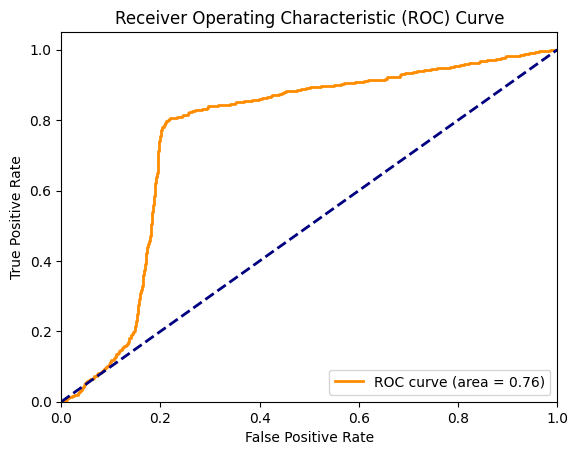

In [11]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_log = log_reg.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_scores_log)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plot ROC curve
plt.figure()
plt.plot(fpr_logistic, tpr_logistic, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_logistic:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


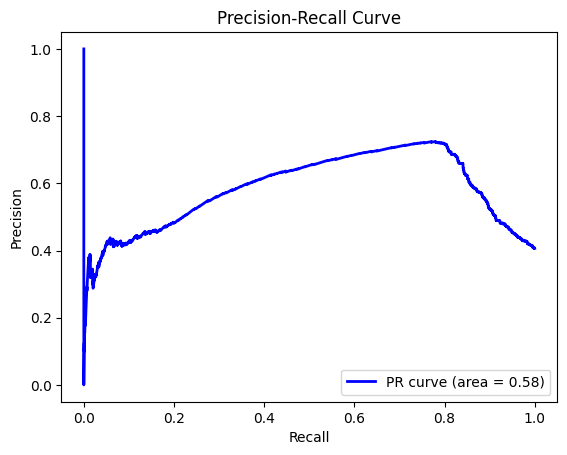

In [12]:
# Compute Precision-Recall curve
precision_curve_logistic, recall_curve_logistic, _ = precision_recall_curve(y_test, y_scores_log)
PR_auc_logistic = auc(recall_curve_logistic, precision_curve_logistic)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_logistic, precision_curve_logistic, color='b', lw=2, label=f'PR curve (area = {PR_auc_logistic:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Random Forest Classifier using LLE dimension reduction**

In [13]:
RF_clf=RandomForestClassifier(max_depth= None, max_features= 'log2', min_samples_split= 10, n_estimators= 200)

RF_clf.fit(X_train_lle_3000, y_train_balanced)

y_pred_RF = RF_clf.predict(X_test_lle_3000)
print("Accuracy:", accuracy_score(y_test, y_pred_RF))
print(classification_report(y_test, y_pred_RF))

Accuracy: 0.785176377328577
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      1498
           1       0.74      0.73      0.73      1025

    accuracy                           0.79      2523
   macro avg       0.78      0.78      0.78      2523
weighted avg       0.78      0.79      0.78      2523



In [14]:
precision_RF = precision_score(y_test, y_pred_RF)
recall_RF = recall_score(y_test, y_pred_RF)
f1_RF = f1_score(y_test, y_pred_RF)
print(f"Precision: {precision_RF:.4f}")
print(f"Recall: {recall_RF:.4f}")
print(f"F1-Score: {f1_RF:.4f}")

Precision: 0.7389
Recall: 0.7288
F1-Score: 0.7338


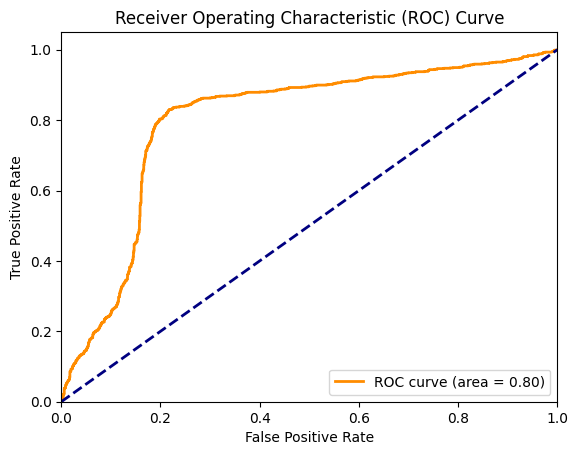

In [15]:
# import matplotlib.pyplot as plt

# Assuming you have the following variables:
# y_true = actual labels
y_scores_RF = RF_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_RF, tpr_RF, thresholds_RF = roc_curve(y_test, y_scores_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

# Plot ROC curve
plt.figure()
plt.plot(fpr_RF, tpr_RF, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_RF:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


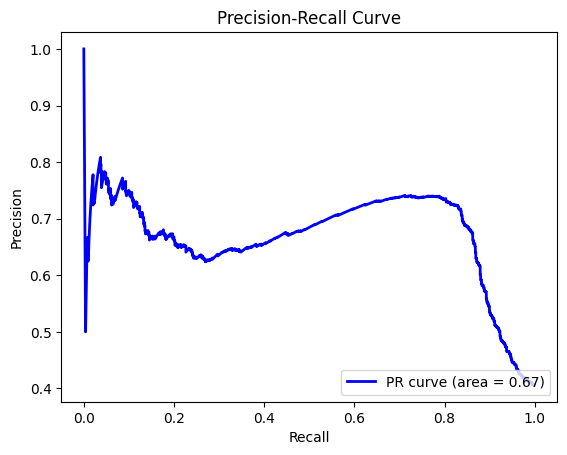

In [16]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_RF, recall_curve_RF, _ = precision_recall_curve(y_test, y_scores_RF)
PR_auc_RF = auc(recall_curve_RF, precision_curve_RF)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_RF, precision_curve_RF, color='b', lw=2, label=f'PR curve (area = {PR_auc_RF:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**LGBM Classifier using LLE dimension reduction**

In [17]:
# Initialize the LGBMClassifier
clf_LGBM = LGBMClassifier(colsample_bytree= 0.692, learning_rate= 0.0331, max_depth= 23, n_estimators= 135\
                          , num_leaves= 47, subsample= 0.972)



clf_LGBM.fit(X_train_lle_3000, y_train_balanced)

y_LGBM = clf_LGBM.predict(X_test_lle_3000)

print("Accuracy:", accuracy_score(y_test, y_LGBM))
print(classification_report(y_test, y_LGBM))


[LightGBM] [Info] Number of positive: 5993, number of negative: 5993
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765000
[LightGBM] [Info] Number of data points in the train set: 11986, number of used features: 3000
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Accuracy: 0.7800237812128419
              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1498
           1       0.73      0.72      0.73      1025

    accuracy                           0.78      2523
   macro avg       0.77      0.77      0.77      2523
weighted avg       0.78      0.78      0.78      2523



In [18]:
precision_LGBM = precision_score(y_test, y_LGBM)
recall_LGBM = recall_score(y_test, y_LGBM)
f1_LGBM = f1_score(y_test, y_LGBM)
print(f"Precision: {precision_LGBM:.4f}")
print(f"Recall: {recall_LGBM:.4f}")
print(f"F1-Score: {f1_LGBM:.4f}")

Precision: 0.7318
Recall: 0.7239
F1-Score: 0.7278


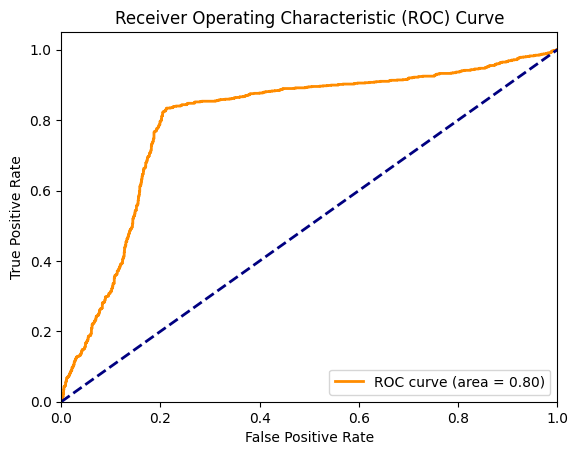

In [19]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_LGBM = clf_LGBM.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_LGBM, tpr_LGBM, thresholds_LGBM = roc_curve(y_test, y_scores_LGBM)
roc_auc_LGBM = auc(fpr_LGBM, tpr_LGBM)

# Plot ROC curve
plt.figure()
plt.plot(fpr_LGBM, tpr_LGBM, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_LGBM:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


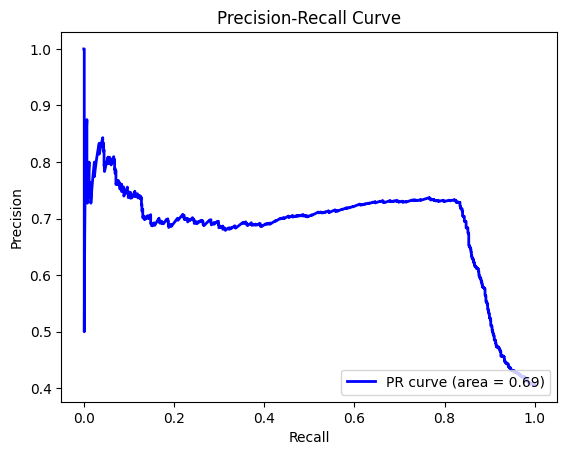

In [20]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_LGBM, recall_curve_LGBM, _ = precision_recall_curve(y_test, y_scores_LGBM)
PR_auc_LGBM = auc(recall_curve_LGBM, precision_curve_LGBM)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_LGBM, precision_curve_LGBM, color='b', lw=2, label=f'PR curve (area = {PR_auc_LGBM:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Ensembling (using soft voting) RF and XGboost using all feature with dimension reduction** 

In [21]:
# Initialize individual classifiers
rf_clf = RandomForestClassifier(
    n_estimators=200, 
    max_depth=None, 
    max_features='log2', 
    min_samples_split=10,
    random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=50, 
    learning_rate=0.1, 
    max_depth=10, 
    subsample=0.8, 
    colsample_bytree=0.8,          
    random_state=42
)

# Create an ensemble using VotingClassifier
ensemble_clf = VotingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf)], 
    voting='soft'  # 'hard' for majority vote; 'soft' uses probabilities
)

# Fit the ensemble model on training data
ensemble_clf.fit(X_train_lle_3000, y_train_balanced)

# Predict on test data
y__ensm = ensemble_clf.predict(X_test_lle_3000)


print("Accuracy:", accuracy_score(y_test, y__ensm))
print("Classification Report:\n", classification_report(y_test, y__ensm))

Accuracy: 0.7768529528339279
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82      1498
           1       0.74      0.70      0.72      1025

    accuracy                           0.78      2523
   macro avg       0.77      0.76      0.77      2523
weighted avg       0.78      0.78      0.78      2523



In [22]:
precision_ensm = precision_score(y_test, y__ensm)
recall_ensm = recall_score(y_test, y__ensm)
f1_ensm = f1_score(y_test, y__ensm)
print(f"Precision: {precision_ensm:.4f}")
print(f"Recall: {recall_ensm:.4f}")
print(f"F1-Score: {f1_ensm:.4f}")

Precision: 0.7372
Recall: 0.7005
F1-Score: 0.7184


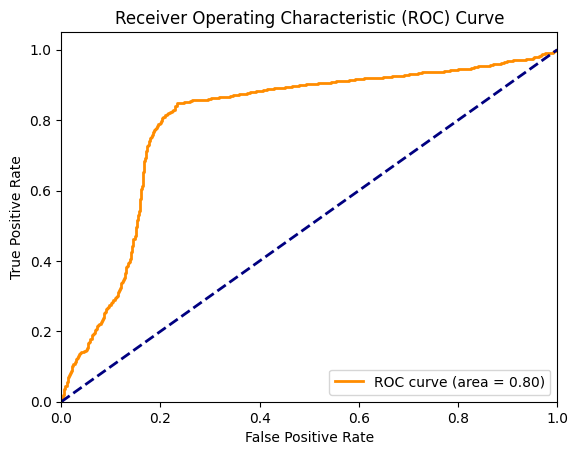

In [23]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_ensm = ensemble_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_ensm, tpr_ensm, thresholds_ensm = roc_curve(y_test, y_scores_ensm)
roc_auc_ensm = auc(fpr_ensm, tpr_ensm)

# Plot ROC curve
plt.figure()
plt.plot(fpr_ensm, tpr_ensm, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_ensm:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


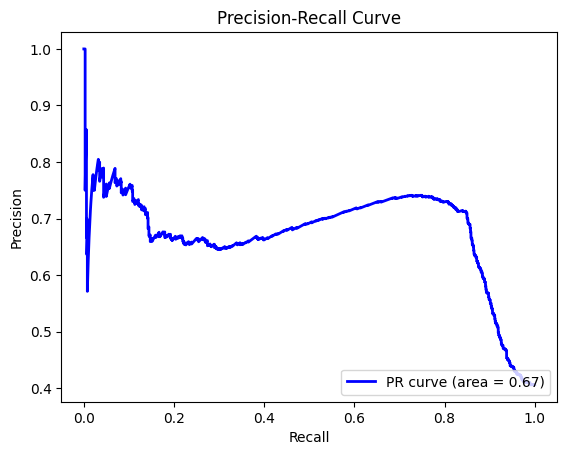

In [24]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_ensm, recall_curve_ensm, _ = precision_recall_curve(y_test, y_scores_ensm)
PR_auc_ensm = auc(recall_curve_ensm, precision_curve_ensm)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_ensm, precision_curve_ensm, color='b', lw=2, label=f'PR curve (area = {PR_auc_ensm:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Stacking RF, XGboost and LGBM and SVM with meta learner logistic**

In [25]:
# Define the base models
rf_clf = RandomForestClassifier(
    n_estimators=200, max_features='log2', min_samples_split=10,max_depth=10, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

lgbm_clf = LGBMClassifier(
    colsample_bytree= 0.69, learning_rate= 0.033, max_depth= 23, n_estimators= 135, num_leaves= 47,\
                                        subsample= 0.972, random_state=42
)

# # 'probability=True' enables soft voting for the meta-learner
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)  


# Define the meta-learner
meta_learner_logreg = LogisticRegression(random_state=42, max_iter=10000,warm_start=True,n_jobs=-1,\
                                         solver='saga',C=10, penalty='l1')

# Update Stacking Classifier with Logistic Regression as the meta-learner
stacking1_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf), ('svm', svm_clf)],
    final_estimator=meta_learner_logreg,
    cv=3,  # Cross-validation for stacking
    n_jobs=-1
)

# Train and evaluate
stacking1_clf.fit(X_train_lle_3000, y_train_balanced)
y_pred_stacking1 = stacking1_clf.predict(X_test_lle_3000)

print("Logistic Regression as Meta-Learner Accuracy:", accuracy_score(y_test, y_pred_stacking1))
print("Classification Report:\n", classification_report(y_test, y_pred_stacking1))

Logistic Regression as Meta-Learner Accuracy: 0.786761791518034
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.82      0.82      1498
           1       0.74      0.74      0.74      1025

    accuracy                           0.79      2523
   macro avg       0.78      0.78      0.78      2523
weighted avg       0.79      0.79      0.79      2523



In [26]:
precision_stack1 = precision_score(y_test, y_pred_stacking1)
recall_stack1 = recall_score(y_test, y_pred_stacking1)
f1_stack1 = f1_score(y_test, y_pred_stacking1)
print(f"Precision: {precision_stack1:.4f}")
print(f"Recall: {recall_stack1:.4f}")
print(f"F1-Score: {f1_stack1:.4f}")

Precision: 0.7385
Recall: 0.7356
F1-Score: 0.7370


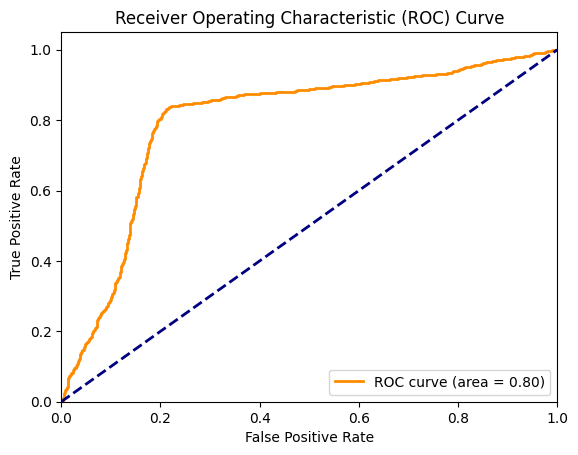

In [27]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_stacking1 = stacking1_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_stack1, tpr_stack1, thresholds_stack1 = roc_curve(y_test, y_scores_stacking1)
roc_auc_stack1 = auc(fpr_stack1, tpr_stack1)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stack1, tpr_stack1, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stack1:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


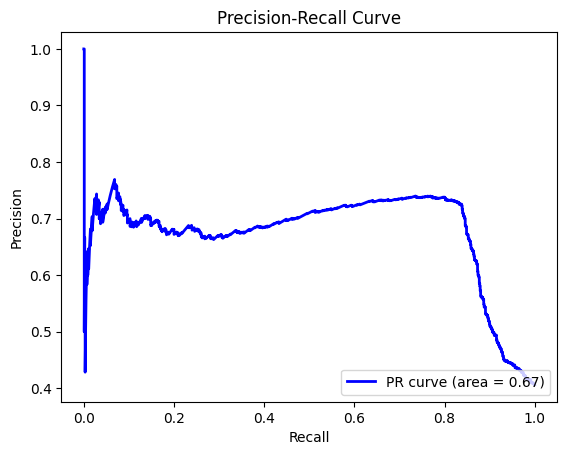

In [28]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_stack1, recall_curve_stack1, _ = precision_recall_curve(y_test, y_scores_stacking1)
PR_auc_stack1 = auc(recall_curve_stack1, precision_curve_stack1)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_stack1, precision_curve_stack1, color='b', lw=2, label=f'PR curve (area = {PR_auc_stack1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Stacking RF, XGboost and LGBM and SVM with meta learner RF**

In [29]:
# Define the base models
rf_clf = RandomForestClassifier(
    n_estimators=200, max_features='log2', min_samples_split=10,max_depth=None, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

lgbm_clf = LGBMClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42
)

# # 'probability=True' enables soft voting for the meta-learner
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)  


# Define the meta-learner
meta_learner = RandomForestClassifier(n_estimators=200, min_samples_split=10,max_depth=None,max_features='log2',\
                                      random_state=42)

# Create the stacking classifier
stacking2_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf),('lgbm',lgbm_clf), ('svm', svm_clf)],
    final_estimator=meta_learner,  # Meta-learner
    cv=3,  # Cross-validation for generalization
    n_jobs=-1
)

# Train the stacking model on training data
stacking2_clf.fit(X_train_lle_3000, y_train_balanced)

# Predict on the test data
y_stacking2 = stacking2_clf.predict(X_test_lle_3000) 

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_stacking2))
print("Classification Report:\n", classification_report(y_test, y_stacking2))


Accuracy: 0.8081648830757036
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.81      0.83      1498
           1       0.74      0.81      0.77      1025

    accuracy                           0.81      2523
   macro avg       0.80      0.81      0.80      2523
weighted avg       0.81      0.81      0.81      2523



In [30]:
precision_stack2 = precision_score(y_test, y_stacking2)
recall_stack2 = recall_score(y_test, y_stacking2)
f1_stack2 = f1_score(y_test, y_stacking2)
print(f"Precision: {precision_stack2:.4f}")
print(f"Recall: {recall_stack2:.4f}")
print(f"F1-Score: {f1_stack2:.4f}")

Precision: 0.7422
Recall: 0.8088
F1-Score: 0.7740


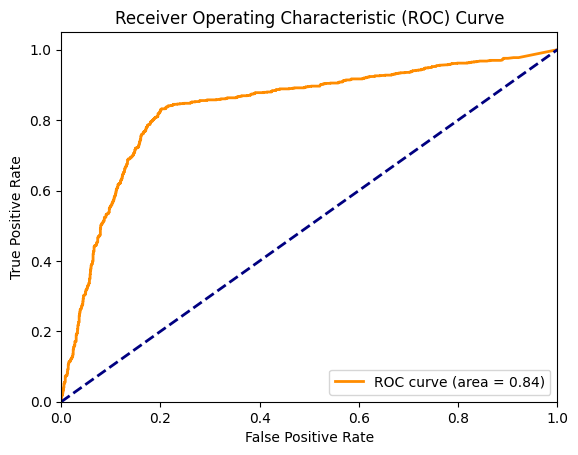

In [31]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_stacking2 = stacking2_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_stack2, tpr_stack2, thresholds_stack2 = roc_curve(y_test, y_scores_stacking2)
roc_auc_stack2 = auc(fpr_stack2, tpr_stack2)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stack2, tpr_stack2, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stack2:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


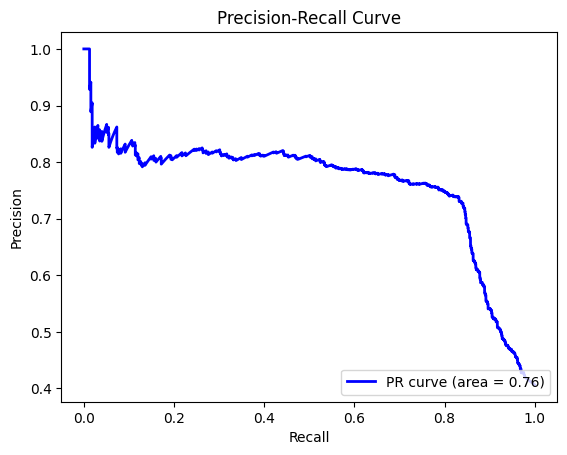

In [32]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_stack2, recall_curve_stack2, _ = precision_recall_curve(y_test, y_scores_stacking2)
PR_auc_stack2 = auc(recall_curve_stack2, precision_curve_stack2)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_stack2, precision_curve_stack2, color='b', lw=2, label=f'PR curve (area = {PR_auc_stack2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Stacking RF, XGboost and LGBM and SVM with meta learner XGboost**

In [33]:
# Define the base models
rf_clf = RandomForestClassifier(
    n_estimators=200, max_features='log2', min_samples_split=10,max_depth=10, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

lgbm_clf = LGBMClassifier(
    n_estimators=292, learning_rate=0.0117,colsample_bytree=0.6795, max_depth=15, num_leaves=36,subsample=0.8845, random_state=42
)

# # 'probability=True' enables soft voting for the meta-learner
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)  


# Define the meta-learner
meta_learner_xgb = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

# Update Stacking Classifier with XGBoost as the meta-learner
stacking3_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf), ('svm', svm_clf)],
    final_estimator=meta_learner_xgb,
    cv=3,
    n_jobs=-1
)

# Train and evaluate
stacking3_clf.fit(X_train_lle_3000, y_train_balanced)
y_stacking3 = stacking3_clf.predict(X_test_lle_3000)

print("XGBoost as Meta-Learner Accuracy:", accuracy_score(y_test, y_stacking3))
print("Classification Report:\n", classification_report(y_test, y_stacking3))

XGBoost as Meta-Learner Accuracy: 0.8156956004756243
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.82      0.84      1498
           1       0.75      0.81      0.78      1025

    accuracy                           0.82      2523
   macro avg       0.81      0.82      0.81      2523
weighted avg       0.82      0.82      0.82      2523



In [34]:
precision_stack3 = precision_score(y_test, y_stacking3)
recall_stack3 = recall_score(y_test, y_stacking3)
f1_stack3 = f1_score(y_test, y_stacking3)
print(f"Precision: {precision_stack3:.4f}")
print(f"Recall: {recall_stack3:.4f}")
print(f"F1-Score: {f1_stack3:.4f}")

Precision: 0.7527
Recall: 0.8137
F1-Score: 0.7820


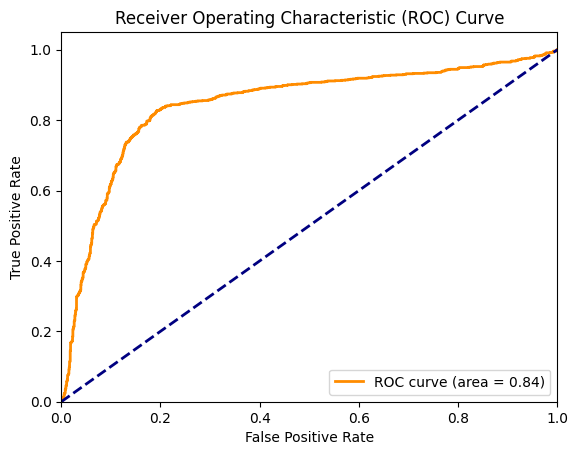

In [35]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_stacking3 = stacking3_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_stack3, tpr_stack3, thresholds_stack3 = roc_curve(y_test, y_scores_stacking3)
roc_auc_stack3 = auc(fpr_stack3, tpr_stack3)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stack3, tpr_stack3, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stack3:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


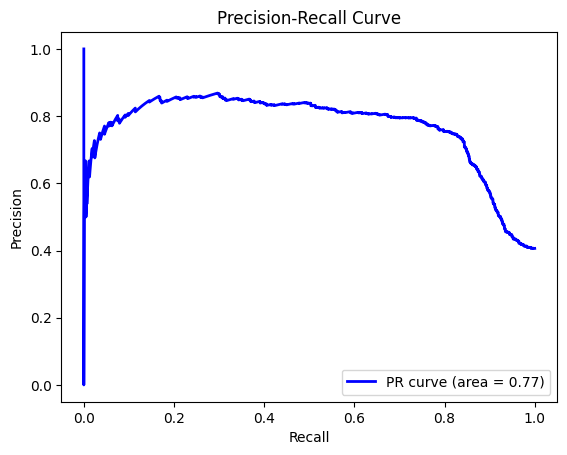

In [36]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_stack3, recall_curve_stack3, _ = precision_recall_curve(y_test, y_scores_stacking3)
PR_auc_stack3 = auc(recall_curve_stack3, precision_curve_stack3)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_stack3, precision_curve_stack3, color='b', lw=2, label=f'PR curve (area = {PR_auc_stack3:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Stacking RF, XGboost and LGBM and SVM with meta learner GradientBoosting**

In [37]:
# Define the base models
rf_clf = RandomForestClassifier(
    n_estimators=200, max_features='log2', min_samples_split=10,max_depth=10, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

lgbm_clf = LGBMClassifier(
    n_estimators=292, learning_rate=0.0117,colsample_bytree=0.6795, max_depth=15, num_leaves=36,subsample=0.8845, random_state=42
)

# # 'probability=True' enables soft voting for the meta-learner
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)  


# Define the meta-learner
meta_learner_gb = GradientBoostingClassifier(
    n_estimators=50, learning_rate=0.1, max_depth=3, random_state=42
)

# Update Stacking Classifier with Gradient Boosting as the meta-learner
stacking4_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf), ('svm', svm_clf)],
    final_estimator=meta_learner_gb,
    cv=3,
    n_jobs=-1
)

# Train and evaluate
stacking4_clf.fit(X_train_lle_3000, y_train_balanced)
y_stacking4 = stacking4_clf.predict(X_test_lle_3000)

print("Gradient Boosting as Meta-Learner Accuracy:", accuracy_score(y_test, y_stacking4))
print("Classification Report:\n", classification_report(y_test, y_stacking4))

Gradient Boosting as Meta-Learner Accuracy: 0.8129211256440745
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.84      1498
           1       0.74      0.83      0.78      1025

    accuracy                           0.81      2523
   macro avg       0.81      0.81      0.81      2523
weighted avg       0.82      0.81      0.81      2523



In [38]:
precision_stack4 = precision_score(y_test, y_stacking4)
recall_stack4 = recall_score(y_test, y_stacking4)
f1_stack4 = f1_score(y_test, y_stacking4)
print(f"Precision: {precision_stack4:.4f}")
print(f"Recall: {recall_stack4:.4f}")
print(f"F1-Score: {f1_stack4:.4f}")

Precision: 0.7428
Recall: 0.8254
F1-Score: 0.7819


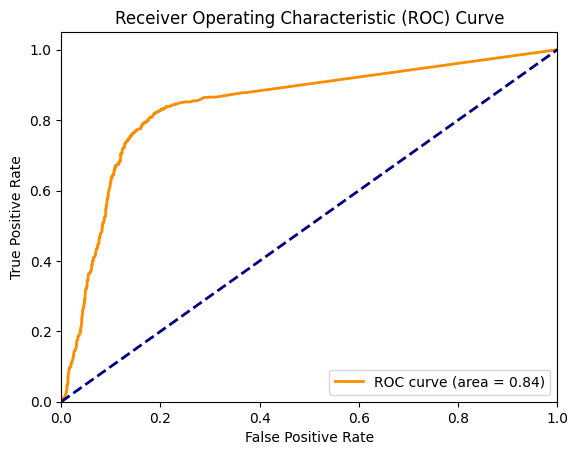

In [39]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_stacking4 = stacking4_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_stack4, tpr_stack4, thresholds_stack4 = roc_curve(y_test, y_scores_stacking4)
roc_auc_stack4 = auc(fpr_stack4, tpr_stack4)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stack4, tpr_stack4, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stack4:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


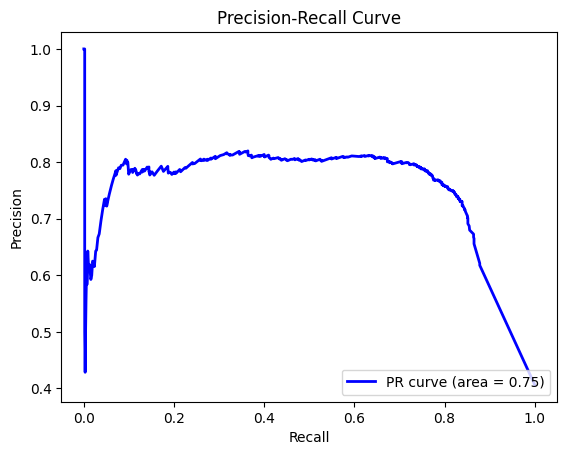

In [40]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_stack4, recall_curve_stack4, _ = precision_recall_curve(y_test, y_scores_stacking4)
PR_auc_stack4 = auc(recall_curve_stack4, precision_curve_stack4)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_stack4, precision_curve_stack4, color='b', lw=2, label=f'PR curve (area = {PR_auc_stack4:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Stacking RF, XGboost and LGBM and SVM with meta learner SVM**

In [41]:
# Define the base models
rf_clf = RandomForestClassifier(
    n_estimators=200, max_features='log2', min_samples_split=10,max_depth=10, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

lgbm_clf = LGBMClassifier(
    n_estimators=292, learning_rate=0.0117,colsample_bytree=0.6795, max_depth=15, num_leaves=36\
    ,subsample=0.8845, random_state=42
)

# # 'probability=True' enables soft voting for the meta-learner
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)  


# Define the meta-learner
meta_learner_svm = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Set up the stacking classifier with SVM as the final meta-learner
stacking5_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('lgbm', lgbm_clf), ('svm_base', svm_clf)],
    final_estimator=meta_learner_svm,
    cv=3,  # Cross-validation for stacking
    n_jobs=-1
)

# Train the stacking model
stacking5_clf.fit(X_train_lle_3000, y_train_balanced)

# Predict and evaluate on the test data
y_stacking5 = stacking5_clf.predict(X_test_lle_3000)

# Display evaluation metrics
print("SVM as Meta-Learner Accuracy:", accuracy_score(y_test, y_stacking5))
print("Classification Report:\n", classification_report(y_test, y_stacking5))

SVM as Meta-Learner Accuracy: 0.8097502972651606
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1498
           1       0.74      0.83      0.78      1025

    accuracy                           0.81      2523
   macro avg       0.80      0.81      0.81      2523
weighted avg       0.82      0.81      0.81      2523



In [ ]:
#joblib.dump(stacking5_clf,'stacking5.pkl')

In [42]:
precision_stack5 = precision_score(y_test, y_stacking5)
recall_stack5 = recall_score(y_test, y_stacking5)
f1_stack5 = f1_score(y_test, y_stacking5)
print(f"Precision: {precision_stack5:.4f}")
print(f"Recall: {recall_stack5:.4f}")
print(f"F1-Score: {f1_stack5:.4f}")

Precision: 0.7363
Recall: 0.8283
F1-Score: 0.7796


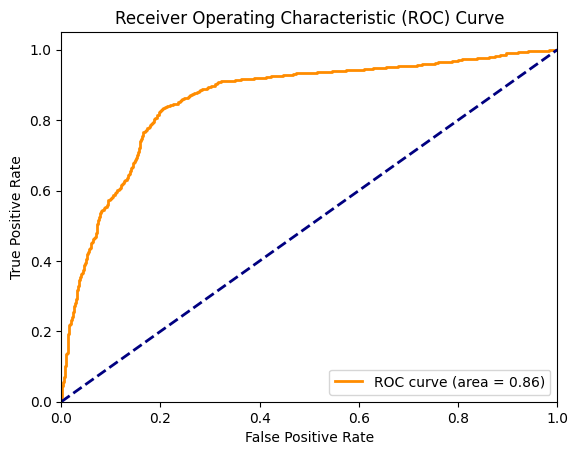

In [43]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_stacking5 = stacking5_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_stack5, tpr_stack5, thresholds_stack5 = roc_curve(y_test, y_scores_stacking5)
roc_auc_stack5 = auc(fpr_stack5, tpr_stack5)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stack5, tpr_stack5, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stack5:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


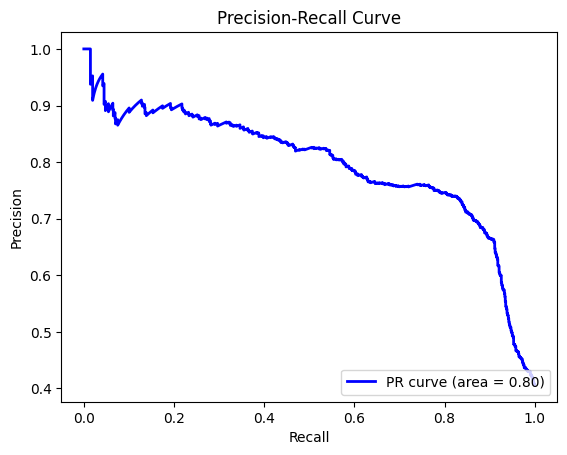

In [44]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_stack5, recall_curve_stack5, _ = precision_recall_curve(y_test, y_scores_stacking5)
PR_auc_stack5 = auc(recall_curve_stack5, precision_curve_stack5)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_stack5, precision_curve_stack5, color='b', lw=2, label=f'PR curve (area = {PR_auc_stack5:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Stacking RF, XGboost and LGBM and SVM with meta learner lgbm**

In [45]:
# Define the base models
rf_clf = RandomForestClassifier(
    n_estimators=200, max_features='log2', min_samples_split=10,max_depth=10, random_state=42
)

xgb_clf = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

lgbm_clf = LGBMClassifier(
    n_estimators=292, learning_rate=0.0117
    ,colsample_bytree=0.6795
    , max_depth=15
    , num_leaves=36
    ,subsample=0.8845
    ,force_col_wise=True,  # Optional based on your choice
    verbose=-1, random_state=42
)

# # 'probability=True' enables soft voting for the meta-learner
svm_clf = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)  


# Define the meta-learner
meta_learner_lgbm = LGBMClassifier(
    n_estimators=292
    , learning_rate=0.0117
    ,colsample_bytree=0.6795
    , max_depth=15, num_leaves=36
    ,subsample=0.8845
    ,force_col_wise=True,  # Optional based on your choice
    verbose=-1
    , random_state=42
)

# Set up the stacking classifier with LightGBM as the final meta-learner
stacking6_clf = StackingClassifier(
    estimators=[('rf', rf_clf), ('xgb', xgb_clf), ('lgbm_base', lgbm_clf), ('svm', svm_clf)],
    final_estimator=meta_learner_lgbm,
    cv=3,  # Cross-validation for stacking
    n_jobs=-1
)

# Train the stacking model
stacking6_clf.fit(X_train_lle_3000, y_train_balanced)

# Predict and evaluate on the test data
y_stacking6 = stacking6_clf.predict(X_test_lle_3000)

# Display evaluation metrics
print("LightGBM as Meta-Learner Accuracy:", accuracy_score(y_test, y_stacking6))
print("Classification Report:\n", classification_report(y_test, y_stacking6))

LightGBM as Meta-Learner Accuracy: 0.813713832738803
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.82      0.84      1498
           1       0.75      0.81      0.78      1025

    accuracy                           0.81      2523
   macro avg       0.81      0.81      0.81      2523
weighted avg       0.82      0.81      0.81      2523



In [46]:
precision_stack6 = precision_score(y_test, y_stacking6)
recall_stack6 = recall_score(y_test, y_stacking6)
f1_stack6 = f1_score(y_test, y_stacking6)
print(f"Precision: {precision_stack6:.4f}")
print(f"Recall: {recall_stack6:.4f}")
print(f"F1-Score: {f1_stack6:.4f}")

Precision: 0.7502
Recall: 0.8117
F1-Score: 0.7798


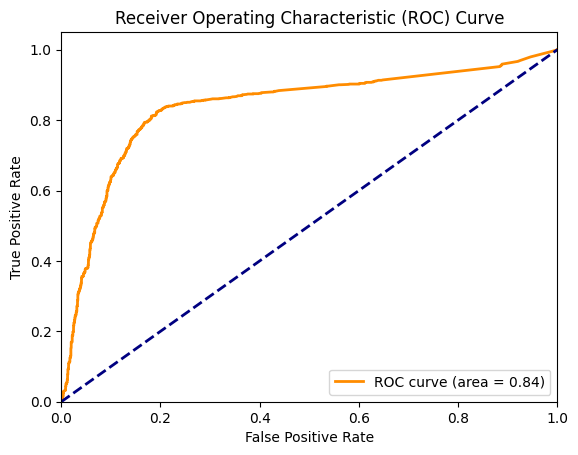

In [47]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_stacking6 = stacking6_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_stack6, tpr_stack6, thresholds_stack6 = roc_curve(y_test, y_scores_stacking6)
roc_auc_stack6 = auc(fpr_stack6, tpr_stack6)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stack6, tpr_stack6, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stack6:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


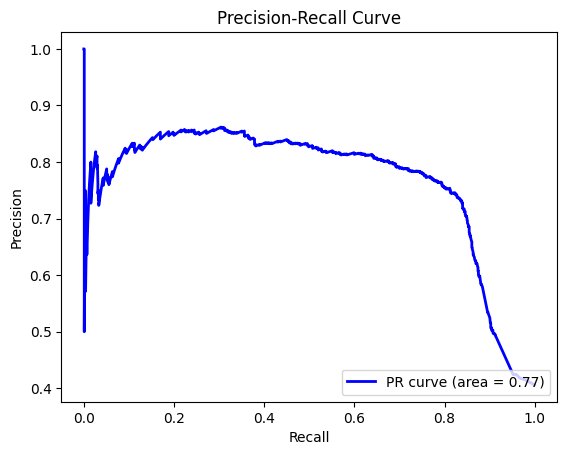

In [48]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_stack6, recall_curve_stack6, _ = precision_recall_curve(y_test, y_scores_stacking6)
PR_auc_stack6 = auc(recall_curve_stack6, precision_curve_stack6)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_stack6, precision_curve_stack6, color='b', lw=2, label=f'PR curve (area = {PR_auc_stack6:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

**Tow-level Stacking**

In [49]:
# Define Level 1 base models

level1_rf = RandomForestClassifier(
    n_estimators=200, max_features='log2', min_samples_split=10, max_depth=10, random_state=42
)
level1_xgb = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42
)
level1_lgbm = LGBMClassifier(
    n_estimators=292, learning_rate=0.0117
    ,colsample_bytree=0.6795
    , max_depth=15
    , num_leaves=36
    ,subsample=0.8845
    ,force_col_wise=True,  # Optional based on your choice
    verbose=-1, random_state=42
)
level1_svm = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)

# Meta-learner for Level 1
level11_meta = LGBMClassifier(
    n_estimators=292, learning_rate=0.0117
    ,colsample_bytree=0.6795
    , max_depth=15
    , num_leaves=36
    ,subsample=0.8845
    ,force_col_wise=True,  # Optional based on your choice
    verbose=-1, random_state=42
)

level12_meta = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)

level13_meta = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, 
    subsample=0.8, colsample_bytree=0.8, random_state=42
)

# Stacking Classifier for Level 1
level11_stacking = StackingClassifier(
    estimators=[('rf', level1_rf), ('xgb', level1_xgb), ('lgbm', level1_lgbm), ('svm', level1_svm)],
    final_estimator=level11_meta,
    cv=3,
    n_jobs=-1
)
level12_stacking = StackingClassifier(
    estimators=[('rf', level1_rf), ('xgb', level1_xgb), ('lgbm', level1_lgbm), ('svm', level1_svm)],
    final_estimator=level12_meta,
    cv=3,
    n_jobs=-1
)

level13_stacking = StackingClassifier(
    estimators=[('rf', level1_rf), ('xgb', level1_xgb), ('lgbm', level1_lgbm), ('svm', level1_svm)],
    final_estimator=level13_meta,
    cv=3,
    n_jobs=-1
)


final_meta = SVC(probability=True, kernel='rbf', C=1.0, gamma='scale', random_state=42)
# CatBoostClassifier(
#     iterations=300,          # Number of boosting iterations
#     learning_rate=0.1,       # Learning rate
#     depth=6,                 # Depth of trees
#     random_state=42,
#     verbose=0                # Suppresses the output
# )

# Level 2 Stacking Model
stacking7_clf = StackingClassifier(
    estimators=[('level2_est1', level11_meta), ('level2_est2', level12_meta), ('level2_est3', level13_meta)],
    final_estimator=final_meta,
    cv=3,
    n_jobs=-1
)

# Train the stacking model
stacking7_clf.fit(X_train_lle_3000, y_train_balanced)

# Predict and evaluate on the test data
y_stacking7= stacking7_clf.predict(X_test_lle_3000)

# Display evaluation metrics
print("LightGBM as Meta-Learner Accuracy:", accuracy_score(y_test, y_stacking7))
print("Classification Report:\n", classification_report(y_test, y_stacking7))


LightGBM as Meta-Learner Accuracy: 0.8097502972651606
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.80      0.83      1498
           1       0.74      0.83      0.78      1025

    accuracy                           0.81      2523
   macro avg       0.80      0.81      0.81      2523
weighted avg       0.82      0.81      0.81      2523



In [ ]:
#joblib.dump(stacking7_clf,'stacking7.pkl')

In [50]:
precision_stack7 = precision_score(y_test, y_stacking7)
recall_stack7 = recall_score(y_test, y_stacking7)
f1_stack7 = f1_score(y_test, y_stacking7)
print(f"Precision: {precision_stack7:.4f}")
print(f"Recall: {recall_stack7:.4f}")
print(f"F1-Score: {f1_stack7:.4f}")

Precision: 0.7363
Recall: 0.8283
F1-Score: 0.7796


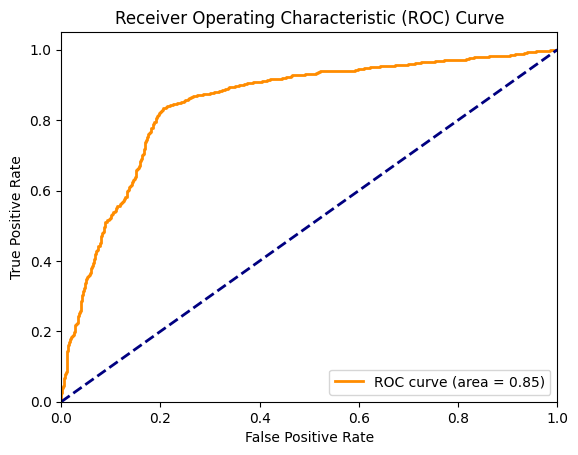

In [51]:
# Assuming you have the following variables:
# y_true = actual labels
y_scores_stacking7 = stacking7_clf.predict_proba(X_test_lle_3000)[:, 1]

# Compute ROC curve and AUC
fpr_stack7, tpr_stack7, thresholds_stack7 = roc_curve(y_test, y_scores_stacking7)
roc_auc_stack7 = auc(fpr_stack7, tpr_stack7)

# Plot ROC curve
plt.figure()
plt.plot(fpr_stack7, tpr_stack7, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_stack7:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


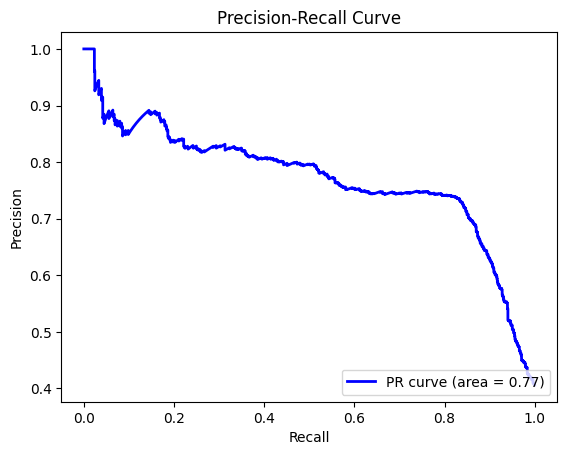

In [52]:
# Assuming you have the following variables:
# y_true = actual labels
# y_scores = predicted probabilities for the positive class

# Compute Precision-Recall curve
precision_curve_stack7, recall_curve_stack7, _ = precision_recall_curve(y_test, y_scores_stacking7)
PR_auc_stack7 = auc(recall_curve_stack7, precision_curve_stack7)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall_curve_stack7, precision_curve_stack7, color='b', lw=2, label=f'PR curve (area = {PR_auc_stack7:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower right")
plt.show()

# Metrics

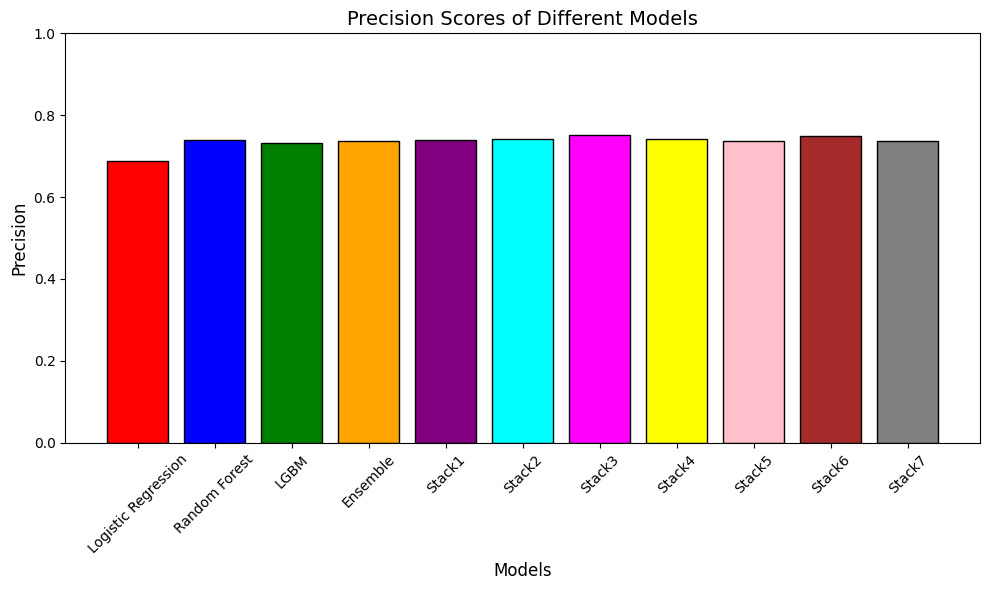

In [53]:
models = ['Logistic Regression', 'Random Forest', 'LGBM', 'Ensemble','Stack1'\
          ,'Stack2','Stack3','Stack4','Stack5','Stack6','Stack7']  # Example model names
precisions = [precision_logistic, precision_RF, precision_LGBM, precision_ensm,precision_stack1\
             ,precision_stack2,precision_stack3,precision_stack4,precision_stack5,precision_stack6\
             ,precision_stack7]  # Example precision scores
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'brown', 'gray']
# Step 2: Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, precisions, color=colors, edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision Scores of Different Models', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the chart
plt.tight_layout()
plt.show()

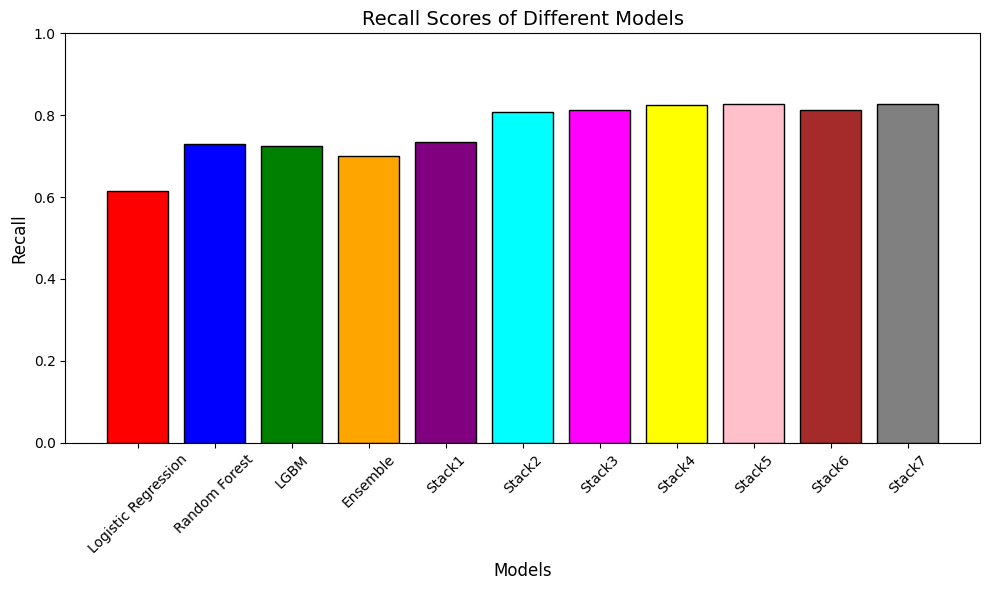

In [54]:
models = ['Logistic Regression', 'Random Forest', 'LGBM', 'Ensemble','Stack1'\
          ,'Stack2','Stack3','Stack4','Stack5','Stack6','Stack7']  # Example model names
recalls = [recall_logistic, recall_RF, recall_LGBM, recall_ensm,recall_stack1\
             ,recall_stack2,recall_stack3,recall_stack4,recall_stack5,recall_stack6\
             ,recall_stack7]  # Example precision scores
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'brown', 'gray']
# Step 2: Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, recalls, color=colors, edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('Recall', fontsize=12)
plt.title('Recall Scores of Different Models', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the chart
plt.tight_layout()
plt.show()

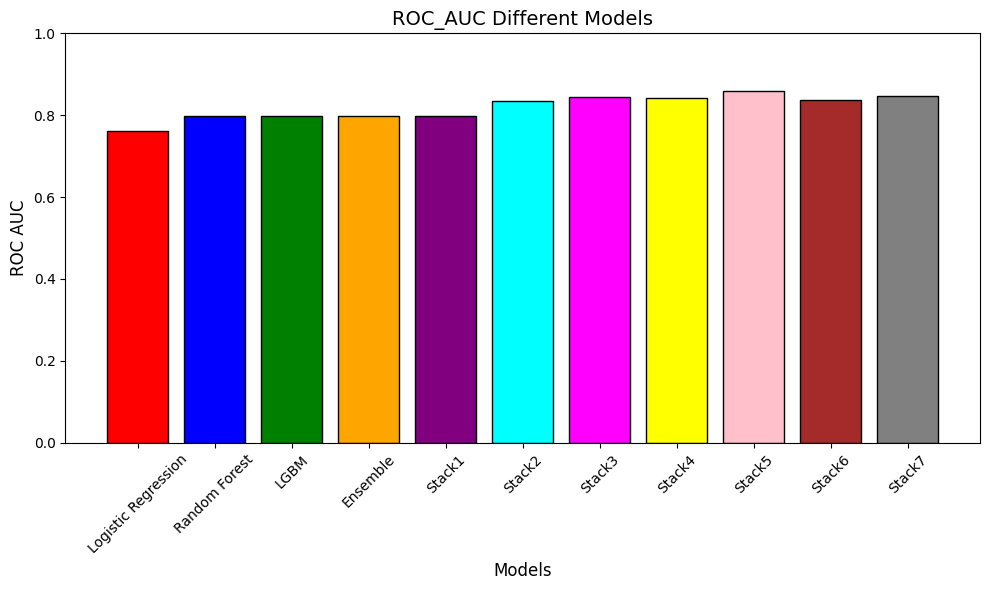

In [55]:
models = ['Logistic Regression', 'Random Forest', 'LGBM', 'Ensemble','Stack1'\
          ,'Stack2','Stack3','Stack4','Stack5','Stack6','Stack7']  # Example model names
roc_auc = [roc_auc_logistic, roc_auc_RF, roc_auc_LGBM, roc_auc_ensm,roc_auc_stack1\
             ,roc_auc_stack2,roc_auc_stack3,roc_auc_stack4,roc_auc_stack5,roc_auc_stack6\
             ,roc_auc_stack7]  # Example precision scores
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'brown', 'gray']
# Step 2: Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, roc_auc, color=colors, edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('ROC AUC', fontsize=12)
plt.title('ROC_AUC Different Models', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the chart
plt.tight_layout()
plt.show()

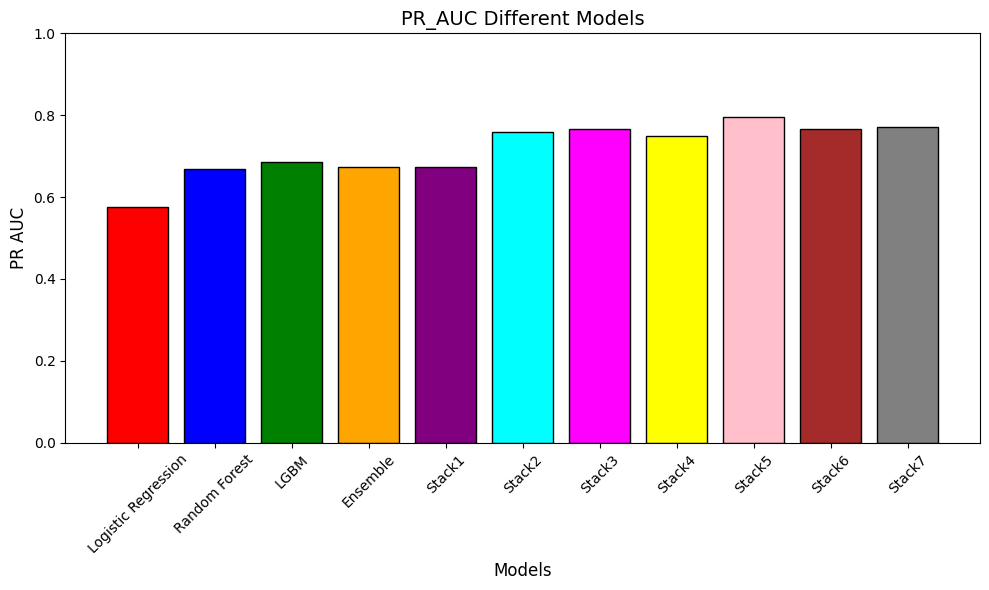

In [56]:
models = ['Logistic Regression', 'Random Forest', 'LGBM', 'Ensemble','Stack1'\
          ,'Stack2','Stack3','Stack4','Stack5','Stack6','Stack7']  # Example model names
PR_auc = [PR_auc_logistic, PR_auc_RF, PR_auc_LGBM, PR_auc_ensm,PR_auc_stack1\
             ,PR_auc_stack2,PR_auc_stack3,PR_auc_stack4,PR_auc_stack5,PR_auc_stack6\
             ,PR_auc_stack7]  # Example precision scores
colors = ['red', 'blue', 'green', 'orange', 'purple', 'cyan', 'magenta', 'yellow', 'pink', 'brown', 'gray']
# Step 2: Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, PR_auc, color=colors, edgecolor='black')

# Step 3: Add labels and title
plt.xlabel('Models', fontsize=12)
plt.ylabel('PR AUC', fontsize=12)
plt.title('PR_AUC Different Models', fontsize=14)
plt.ylim(0, 1)  # Set y-axis limit to [0, 1] for better visualization
plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Display the chart
plt.tight_layout()
plt.show()

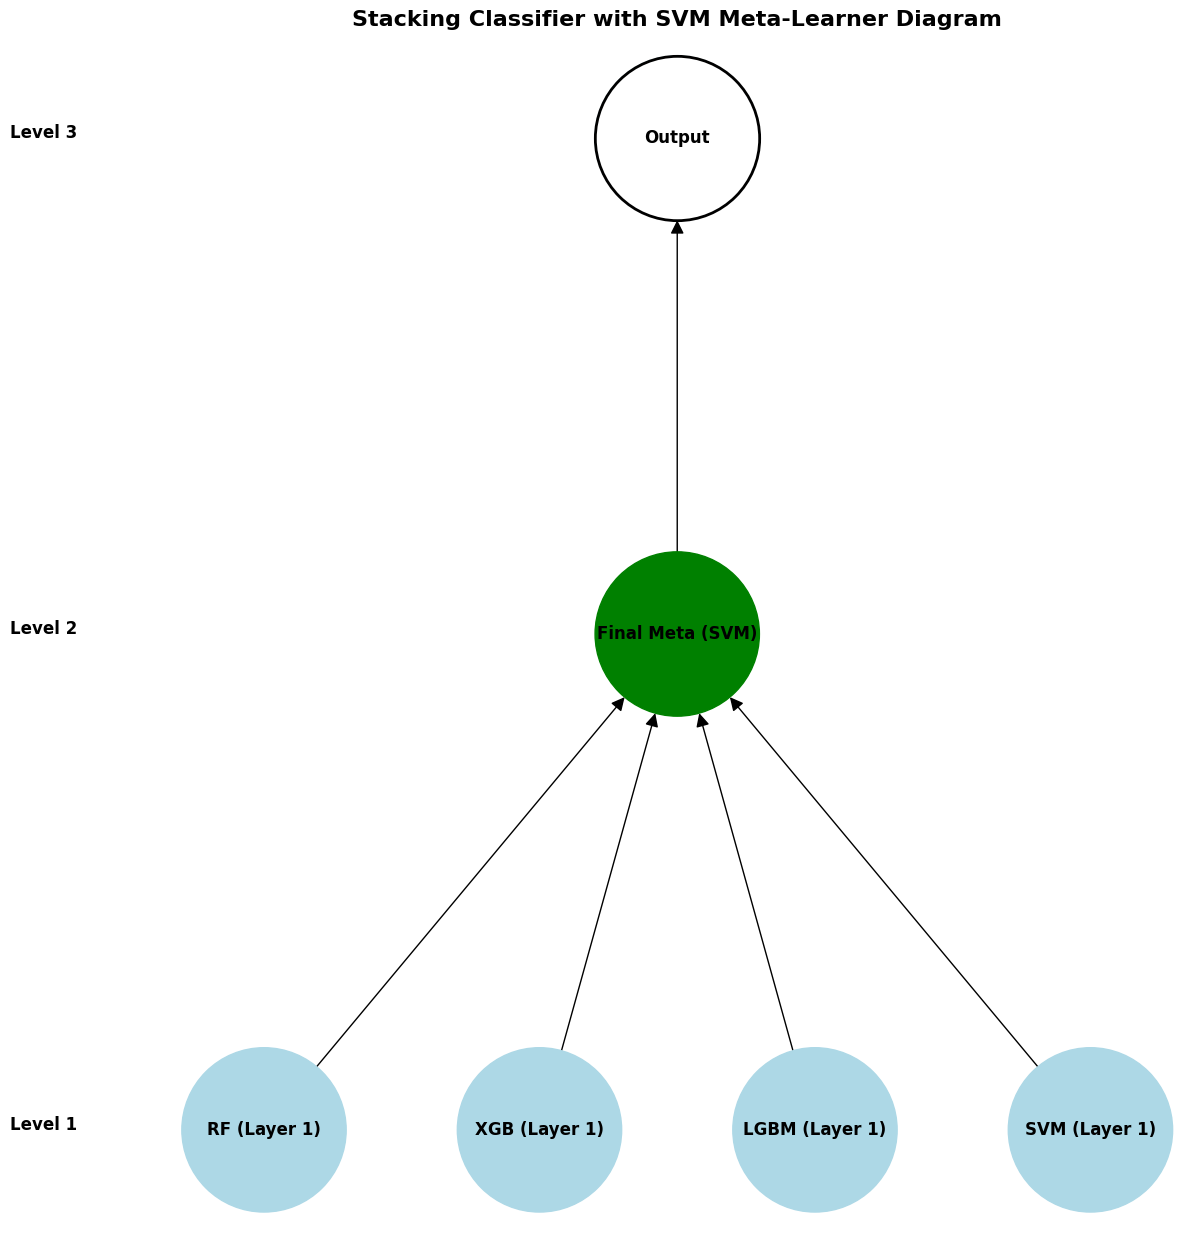

In [57]:
# Create a directed graph
G = nx.DiGraph()

# Nodes for Layer 1
G.add_node("RF (Layer 1)", pos=(1, 0))
G.add_node("XGB (Layer 1)", pos=(2, 0))
G.add_node("LGBM (Layer 1)", pos=(3, 0))
G.add_node("SVM (Layer 1)", pos=(4, 0))

# Node for Layer 3 (Final Meta-Learner)
G.add_node("Final Meta (SVM)", pos=(2.5, 1))
# Node for Output
G.add_node("Output", pos=(2.5, 2))

# Add edges between layers
edges = [
    # Layer 1 to Layer 2
    ("RF (Layer 1)", "Final Meta (SVM)"), ("XGB (Layer 1)", "Final Meta (SVM)"),
    ("LGBM (Layer 1)", "Final Meta (SVM)"), ("SVM (Layer 1)", "Final Meta (SVM)"),
    # Layer 2 to Output
    ("Final Meta (SVM)", "Output")
]
G.add_edges_from(edges)

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Define node color map
node_colors = {
    "RF (Layer 1)": "lightblue", "XGB (Layer 1)": "lightblue", 
    "LGBM (Layer 1)": "lightblue", "SVM (Layer 1)": "lightblue",
    "Final Meta (SVM)": "green"
}

# Extract colors for the nodes
colors = [node_colors.get(node, "lightblue") for node in G.nodes()]


# Plot the graph
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 12))
nx.draw(
    G, pos, with_labels=True, node_size=14000, node_color=colors, 
    font_size=12, font_weight='bold', arrowsize=20
)

# Add the Output node separately to customize its appearance
nx.draw_networkx_nodes(
    G, pos, nodelist=["Output"], node_color="white", edgecolors="black", 
    node_size=14000, linewidths=2
)


# Add level annotations
plt.text(0.2, 0, "Level 1", fontsize=12, fontweight='bold', ha='center')
plt.text(0.2, 1, "Level 2", fontsize=12, fontweight='bold', ha='center')
plt.text(0.2, 2, "Level 3", fontsize=12, fontweight='bold', ha='center')

# Add title
plt.title("Stacking Classifier with SVM Meta-Learner Diagram", fontsize=16, fontweight='bold')
plt.show()


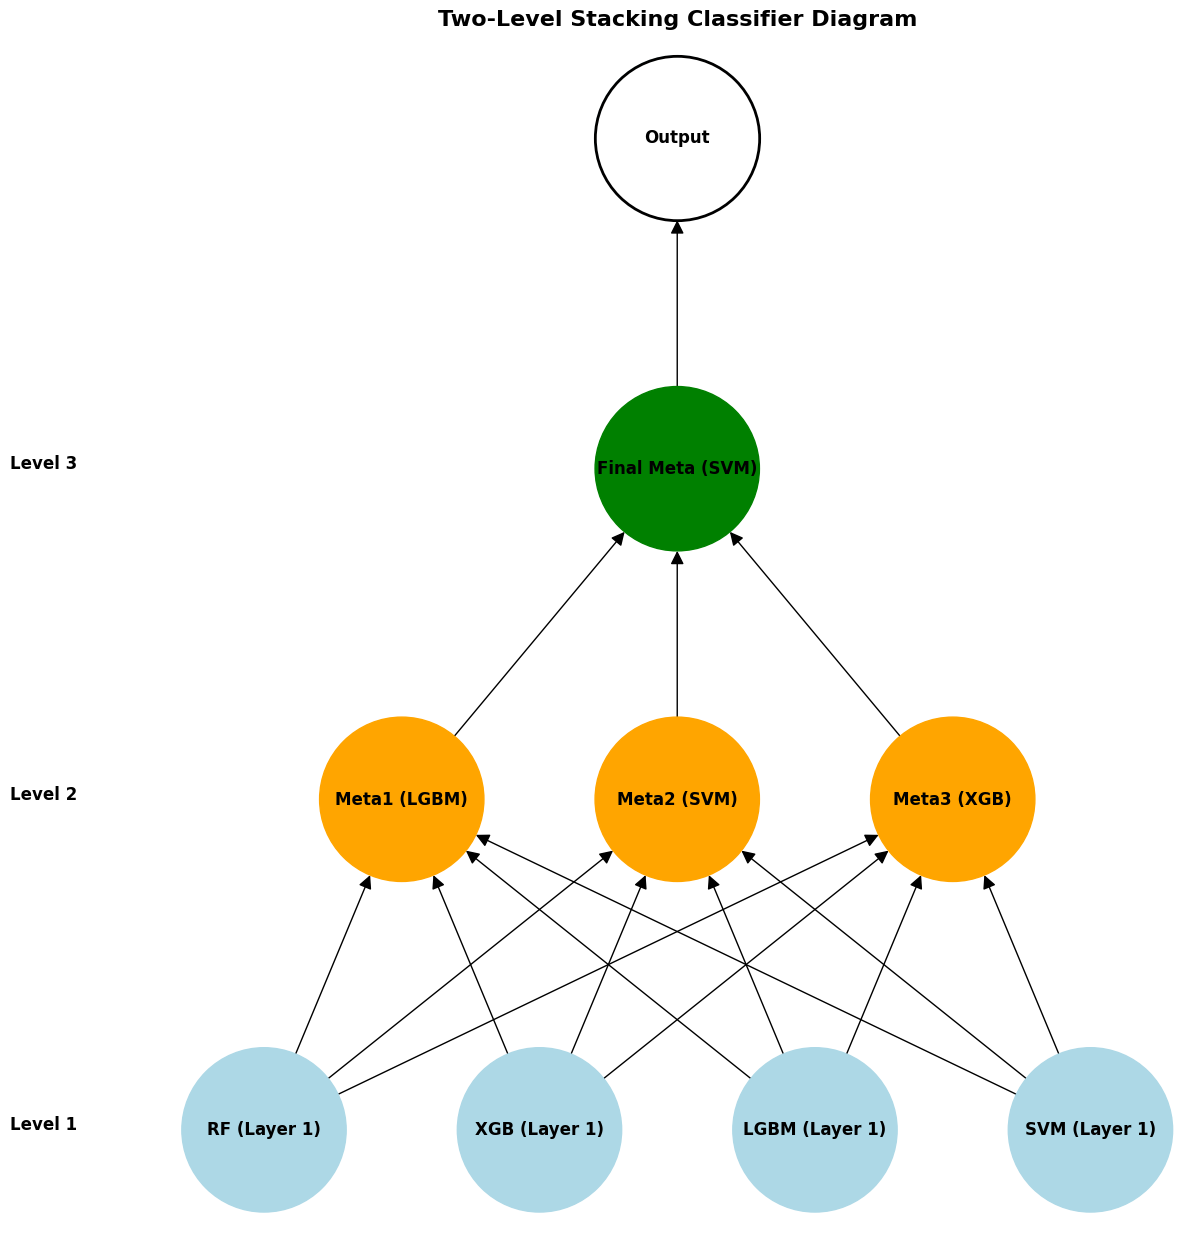

In [59]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Nodes for Layer 1
G.add_node("RF (Layer 1)", pos=(1, 0))
G.add_node("XGB (Layer 1)", pos=(2, 0))
G.add_node("LGBM (Layer 1)", pos=(3, 0))
G.add_node("SVM (Layer 1)", pos=(4, 0))

# Nodes for Layer 2
G.add_node("Meta1 (LGBM)", pos=(1.5, 1))
G.add_node("Meta2 (SVM)", pos=(2.5, 1))
G.add_node("Meta3 (XGB)", pos=(3.5, 1))

# Node for Layer 3 (Final Meta-Learner)
G.add_node("Final Meta (SVM)", pos=(2.5, 2))

# Node for Output
G.add_node("Output", pos=(2.5, 3))

# Add edges between layers
edges = [
    # Layer 1 to Layer 2
    ("RF (Layer 1)", "Meta1 (LGBM)"), ("XGB (Layer 1)", "Meta1 (LGBM)"),
    ("LGBM (Layer 1)", "Meta1 (LGBM)"), ("SVM (Layer 1)", "Meta1 (LGBM)"),
    ("RF (Layer 1)", "Meta2 (SVM)"), ("XGB (Layer 1)", "Meta2 (SVM)"),
    ("LGBM (Layer 1)", "Meta2 (SVM)"), ("SVM (Layer 1)", "Meta2 (SVM)"),
    ("RF (Layer 1)", "Meta3 (XGB)"), ("XGB (Layer 1)", "Meta3 (XGB)"),
    ("LGBM (Layer 1)", "Meta3 (XGB)"), ("SVM (Layer 1)", "Meta3 (XGB)"),
    # Layer 2 to Layer 3
    ("Meta1 (LGBM)", "Final Meta (SVM)"), ("Meta2 (SVM)", "Final Meta (SVM)"),
    ("Meta3 (XGB)", "Final Meta (SVM)"),
    # Layer 3 to Output
    ("Final Meta (SVM)", "Output")
]
G.add_edges_from(edges)

# Get positions
pos = nx.get_node_attributes(G, 'pos')

# Define node color map
node_colors = {
    "RF (Layer 1)": "lightblue", "XGB (Layer 1)": "lightblue", 
    "LGBM (Layer 1)": "lightblue", "SVM (Layer 1)": "lightblue",
    "Meta1 (LGBM)": "orange", "Meta2 (SVM)": "orange", 
    "Meta3 (XGB)": "orange",
    "Final Meta (SVM)": "green"
}

# Extract colors for the nodes
colors = [node_colors.get(node, "lightblue") for node in G.nodes()]

# Plot the graph
pos = nx.get_node_attributes(G, 'pos')
plt.figure(figsize=(10, 12))
nx.draw(
    G, pos, with_labels=True, node_size=14000, node_color=colors, 
    font_size=12, font_weight='bold', arrowsize=20
)

# Add the Output node separately to customize its appearance
nx.draw_networkx_nodes(
    G, pos, nodelist=["Output"], node_color="white", edgecolors="black", 
    node_size=14000, linewidths=2
)

# Add level annotations
plt.text(0.2, 0, "Level 1", fontsize=12, fontweight='bold', ha='center')
plt.text(0.2, 1, "Level 2", fontsize=12, fontweight='bold', ha='center')
plt.text(0.2, 2, "Level 3", fontsize=12, fontweight='bold', ha='center')

# Add title
plt.title("Two-Level Stacking Classifier Diagram", fontsize=16, fontweight='bold')
plt.show()
